# Pipeline and Set-Up (Same as Pipeline Notebook)

## Load Libraries

In [ ]:
import seaborn as sns
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import urllib.request
import os

In [ ]:
!pip install kagglehub
!pip install kagglehub[pandas-datasets]
!pip install wget
!pip install -q tensorflow tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/images_resized.zip'
extract_path = '/content/chest_xray_images'

!unzip -q "$zip_path" -d "$extract_path"

Mounted at /content/drive


In [ ]:
#Sanity Check - should say 38008 images
image_dir = os.path.join(extract_path, 'images_resized')

# Check if the directory exists
if os.path.exists(image_dir):
    num_files = len([name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))])
    print(f"Number of files in 'images_resized': {num_files}")
else:
    print(f"Directory 'images_resized' not found in '{extract_path}'")

Number of files in 'images_resized': 38008


## Load Dataset

In [ ]:
# Set the dataset path
dataset_name = "nih-chest-xrays/data"
version = 3
# Set the path to the file you'd like to load
file_path = "Data_Entry_2017.csv"
file_path_bbox = "BBox_List_2017.csv"

gcloud_url_base = 'https://storage.googleapis.com/gcs-public-data--healthcare-nih-chest-xray/png/'

In [ ]:
# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  dataset_name,
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

df_box_list = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  dataset_name,
  file_path_bbox
)

<ipython-input-12-1e51267dc0e1>:2: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(
<ipython-input-12-1e51267dc0e1>:12: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df_box_list = kagglehub.load_dataset(


In [ ]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


None

## Remove all where "View Position" column value is "AP"
AP means "anteroposterior dimension" which is an X-ray from front-to-back This wil affect the training with both back-to-front and front-to-back images of MRIs

In [ ]:
# Entries before removal
print(f"Before 'AP' removal: {df['View Position'].value_counts()}")

# Entries after removal
df = df[df['View Position'] != 'AP']

# Remaining data is 66.57% of total initial data
print(f"After 'AP' removal: {df['View Position'].value_counts()}")

Before 'AP' removal: View Position
PA    67310
AP    44810
Name: count, dtype: int64
After 'AP' removal: View Position
PA    67310
Name: count, dtype: int64


In [ ]:
links = [
    "https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz",
    "https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz",
    "https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz",
    "https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz",
    "https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz",
    "https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz",
    "https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz",
    "https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz",
    "https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz",
    "https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz",
    "https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz",
    "https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz",
]

In [ ]:
# Create a dictionary for folder locations
folder_ranges = {
    "images_001": (0, 4998),  # Adjusted to 0-based index
    "images_002": (4999, 14998),
    "images_003": (14999, 24998),
    "images_004": (24999, 34998),
    "images_005": (34999, 44998),
    "images_006": (44999, 54998),
    "images_007": (54999, 64998),
    "images_008": (64999, 74998),
    "images_009": (74999, 84998),
    "images_010": (84999, 94998),
    "images_011": (94999, 104998),
    "images_012": (104999, 112120)
}

def get_image_folder(df, image_name):
    if image_name in df["Image Index"].values:
        image_index = df[df["Image Index"] == image_name].index[0]  # Get row index
        # print(f"Image {image_name} is at index {image_index}")  # Debugging output

        for folder, (start, end) in folder_ranges.items():
            if start <= image_index <= end:
                return folder

    return None  # If not found

In [ ]:
#Sanity Check
display(df.head())
display(df.tail())
display(df.columns)

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN  
1                        0.143  0.143          NaN  
2                        0.168  0.168          NaN  
3                        0.171  0.171          NaN  
4                        0.143  0.143          NaN

Image Index  Finding Labels  Follow-up #  Patient ID  \
112115  00030801_001.png  Mass|Pneumonia            1       30801   
112116  00030802_000.png      No Finding            0       30802   
112117  00030803_000.png      No Finding            0       30803   
112118  00030804_000.png      No Finding            0       30804   
112119  00030805_000.png      No Finding            0       30805   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
112115           39              M            PA                 2048   
112116           29              M            PA                 2048   
112117           42              F            PA                 2048   
112118           30              F            PA                 2048   
112119           27              M            PA                 2048   

        Height]  OriginalImagePixelSpacing[x     y]  Unnamed: 11  
112115     2500                        0.168  0.168          NaN  
112116     2500                        0.168  0.168          NaN  
112117     2500                        0.168  0.168          NaN  
112118     2500                        0.168  0.168          NaN  
112119     2500                        0.171  0.171          NaN

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')

## We want to have 7 generalized classes from the original 15
Take values from "Finding Labels" and convert them into more generalized labels

In [ ]:
# Create a list to store all unique labels
all_labels = []

# Iterate over the 'Finding Labels' column
for index, row in df.iterrows():
    labels = row['Finding Labels'].split('|')
    for label in labels:
        all_labels.append(label)

# Get unique labels and print them
all_labels = list(set(all_labels))
print(f"All possible options in 'Finding Labels': {all_labels}")

All possible options in 'Finding Labels': ['Pleural_Thickening', 'Emphysema', 'Mass', 'Cardiomegaly', 'Infiltration', 'Pneumothorax', 'No Finding', 'Pneumonia', 'Fibrosis', 'Edema', 'Atelectasis', 'Consolidation', 'Hernia', 'Effusion', 'Nodule']


In [ ]:
def generalize_labels(label):
    if label in ['Pneumonia', 'Consolidation', 'Infiltration']:
        return 'Infection/Infiltration'
    elif label in ['Edema', 'Effusion', 'Pleural_Thickening']:
        return 'Fluid Related Issues'
    elif label in ['Atelectasis', 'Pneumothorax', 'Fibrosis', 'Emphysema']:
        return 'Lung Structure Issues'
    elif label in ['Nodule', 'Mass']:
        return 'Nodule/Mass'
    elif label == 'Cardiomegaly':
        return 'Cardiac Issues'
    elif label == 'Hernia':
        return 'Hernia'
    else:
        return label  # If we don't detect an issue 'No Finding'


df['Finding Labels'] = df['Finding Labels'].apply(lambda x: '|'.join([generalize_labels(label) for label in x.split('|')]))

# Example:
display(df.head()) # View the updated DataFrame

Image Index                        Finding Labels  Follow-up #  \
0  00000001_000.png                        Cardiac Issues            0   
1  00000001_001.png  Cardiac Issues|Lung Structure Issues            1   
2  00000001_002.png   Cardiac Issues|Fluid Related Issues            2   
3  00000002_000.png                            No Finding            0   
4  00000003_000.png                                Hernia            0   

   Patient ID  Patient Age Patient Gender View Position  OriginalImage[Width  \
0           1           58              M            PA                 2682   
1           1           58              M            PA                 2894   
2           1           58              M            PA                 2500   
3           2           81              M            PA                 2500   
4           3           81              F            PA                 2582   

   Height]  OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0     2749                        0.143  0.143          NaN  
1     2729                        0.143  0.143          NaN  
2     2048                        0.168  0.168          NaN  
3     2048                        0.171  0.171          NaN  
4     2991                        0.143  0.143          NaN

In [ ]:
display(df.describe())
display(df.info())

Follow-up #    Patient ID   Patient Age  OriginalImage[Width  \
count  67310.000000  67310.000000  67310.000000         67310.000000   
mean       4.786317  14396.542802     47.352979          2632.590016   
std        9.403191   8559.885944     16.289550           374.573816   
min        0.000000      1.000000      1.000000          1143.000000   
25%        0.000000   7157.250000     36.000000          2500.000000   
50%        1.000000  14112.000000     49.000000          2678.000000   
75%        5.000000  21117.750000     59.000000          2992.000000   
max      156.000000  30805.000000    412.000000          3056.000000   

            Height]  OriginalImagePixelSpacing[x            y]  Unnamed: 11  
count  67310.000000                 67310.000000  67310.000000          0.0  
mean    2652.208468                     0.153868      0.153868          NaN  
std      396.607849                     0.017179      0.017179          NaN  
min     1001.000000                     0.115000      0.115000          NaN  
25%     2411.000000                     0.143000      0.143000          NaN  
50%     2885.000000                     0.143000      0.143000          NaN  
75%     2991.000000                     0.168000      0.168000          NaN  
max     3056.000000                     0.194336      0.194336          NaN

<class 'pandas.core.frame.DataFrame'>
Index: 67310 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  67310 non-null  object 
 1   Finding Labels               67310 non-null  object 
 2   Follow-up #                  67310 non-null  int64  
 3   Patient ID                   67310 non-null  int64  
 4   Patient Age                  67310 non-null  int64  
 5   Patient Gender               67310 non-null  object 
 6   View Position                67310 non-null  object 
 7   OriginalImage[Width          67310 non-null  int64  
 8   Height]                      67310 non-null  int64  
 9   OriginalImagePixelSpacing[x  67310 non-null  float64
 10  y]                           67310 non-null  float64
 11  Unnamed: 11                  0 non-null      float64
dtypes: float64(3), int64(5), object(4)
memory usage: 6.7+ MB


None

In [ ]:
df['Finding Labels'].info()
df['Finding Labels'].head()
df.head()

<class 'pandas.core.series.Series'>
Index: 67310 entries, 0 to 112119
Series name: Finding Labels
Non-Null Count  Dtype 
--------------  ----- 
67310 non-null  object
dtypes: object(1)
memory usage: 1.0+ MB


Image Index                        Finding Labels  Follow-up #  \
0  00000001_000.png                        Cardiac Issues            0   
1  00000001_001.png  Cardiac Issues|Lung Structure Issues            1   
2  00000001_002.png   Cardiac Issues|Fluid Related Issues            2   
3  00000002_000.png                            No Finding            0   
4  00000003_000.png                                Hernia            0   

   Patient ID  Patient Age Patient Gender View Position  OriginalImage[Width  \
0           1           58              M            PA                 2682   
1           1           58              M            PA                 2894   
2           1           58              M            PA                 2500   
3           2           81              M            PA                 2500   
4           3           81              F            PA                 2582   

   Height]  OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0     2749                        0.143  0.143          NaN  
1     2729                        0.143  0.143          NaN  
2     2048                        0.168  0.168          NaN  
3     2048                        0.171  0.171          NaN  
4     2991                        0.143  0.143          NaN

## Pre-processing - Column Clean Up and Encoding

In [ ]:
# Reduce rows with 'No Finding' label to a maximum of 10,000
no_finding_df = df[df['Finding Labels'] == 'No Finding']
if len(no_finding_df) > 10000:
    no_finding_df = no_finding_df.sample(n=10000, random_state=42)  # Randomly sample 10,000 rows

# Concatenate the reduced 'No Finding' rows with other rows
other_findings_df = df[df['Finding Labels'] != 'No Finding']
df = pd.concat([no_finding_df, other_findings_df], ignore_index=True)

In [ ]:
image_files = set(os.listdir('/content/chest_xray_images/images_resized'))
missing_files = df[~df['Image Index'].isin(image_files)]
print("Number of missing images:", len(missing_files))


Number of missing images: 0


In [ ]:
# Rename columns
df = df.rename(columns={
    "OriginalImage[Width": "width",
    "Height]": "height",
    "OriginalImagePixelSpacing[x": "pixel_spacing x",
    "y]": "pixel_spacing y"
})

# drop 'Unnamed: 11' column
df = df.drop(columns=['Unnamed: 11'], errors='ignore')

display(df.head())

Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
0  00019856_000.png     No Finding            0       19856           57   
1  00001020_000.png     No Finding            0        1020           52   
2  00008187_001.png     No Finding            1        8187           59   
3  00003360_003.png     No Finding            3        3360            8   
4  00014364_000.png     No Finding            0       14364           26   

  Patient Gender View Position  width  height  pixel_spacing x  \
0              M            PA   2992    2991            0.143   
1              M            PA   2500    2048            0.171   
2              M            PA   2500    2048            0.168   
3              M            PA   2048    2500            0.168   
4              F            PA   2454    2991            0.143   

   pixel_spacing y  
0            0.143  
1            0.171  
2            0.168  
3            0.168  
4            0.143

In [ ]:
# Extract all unique labels
all_labels = sorted(set(label for sublist in df['Finding Labels'].str.split('|') for label in sublist))
display(all_labels)

# Encode multi-labels
def encode_multilabel(labels):
    label_set = labels.split('|')
    return [1 if label in label_set else 0 for label in all_labels]

df['encoded_labels'] = df['Finding Labels'].apply(encode_multilabel)
display(df.head())

y = np.array(df['encoded_labels'].tolist())

['Cardiac Issues',
 'Fluid Related Issues',
 'Hernia',
 'Infection/Infiltration',
 'Lung Structure Issues',
 'No Finding',
 'Nodule/Mass']

Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
0  00019856_000.png     No Finding            0       19856           57   
1  00001020_000.png     No Finding            0        1020           52   
2  00008187_001.png     No Finding            1        8187           59   
3  00003360_003.png     No Finding            3        3360            8   
4  00014364_000.png     No Finding            0       14364           26   

  Patient Gender View Position  width  height  pixel_spacing x  \
0              M            PA   2992    2991            0.143   
1              M            PA   2500    2048            0.171   
2              M            PA   2500    2048            0.168   
3              M            PA   2048    2500            0.168   
4              F            PA   2454    2991            0.143   

   pixel_spacing y         encoded_labels  
0            0.143  [0, 0, 0, 0, 0, 1, 0]  
1            0.171  [0, 0, 0, 0, 0, 1, 0]  
2            0.168  [0, 0, 0, 0, 0, 1, 0]  
3            0.168  [0, 0, 0, 0, 0, 1, 0]  
4            0.143  [0, 0, 0, 0, 0, 1, 0]

In [ ]:
import tensorflow as tf
import os
import numpy as np

# Define constants
IMG_SIZE = 1024
BATCH_SIZE = 8
IMAGE_PATH = '/content/chest_xray_images/images_resized'

def load_image(image_id):
    image_path = os.path.join(IMAGE_PATH, image_id.numpy().decode('utf-8'))
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.cast(image, tf.float32)  # <-- this line fixes the dtype mismatch
    image = image / 255.0
    return image

# Parsing function for tf.data.Dataset
def parse_function(filename, label, augment=False):
    image = tf.py_function(func=load_image, inp=[filename], Tout=tf.float32)
    image.set_shape([IMG_SIZE, IMG_SIZE, 3])
    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=1.0, upper=1.2)  # only increases contrast
    return image, label

# Extract filenames and labels from DataFrame
image_filenames = df['Image Index'].values
labels = np.array(df['encoded_labels'].tolist(), dtype=np.float32)

# Build the dataset
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, labels))
dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# Intial Training

These next blocks were our initial first few rounds of training EfficientNet. We explored many different possible hyper parameters over several different epoch.

## Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

trainval_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(trainval_df, test_size=0.2, random_state=42)

In [ ]:
# Build datasets for training and validation
def build_dataset_from_df(dataframe, augment=False):
    filenames = dataframe['Image Index'].values
    labels = np.array(dataframe['encoded_labels'].tolist(), dtype=np.float32)
    ds = tf.data.Dataset.from_tensor_slices((filenames, labels))
    ds = ds.map(lambda x, y: parse_function(x, y, augment), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

# Only augment training data
train_dataset = build_dataset_from_df(train_df, augment=True)
val_dataset   = build_dataset_from_df(val_df, augment=False)
test_dataset  = build_dataset_from_df(test_df, augment=False)

## Sanity Check

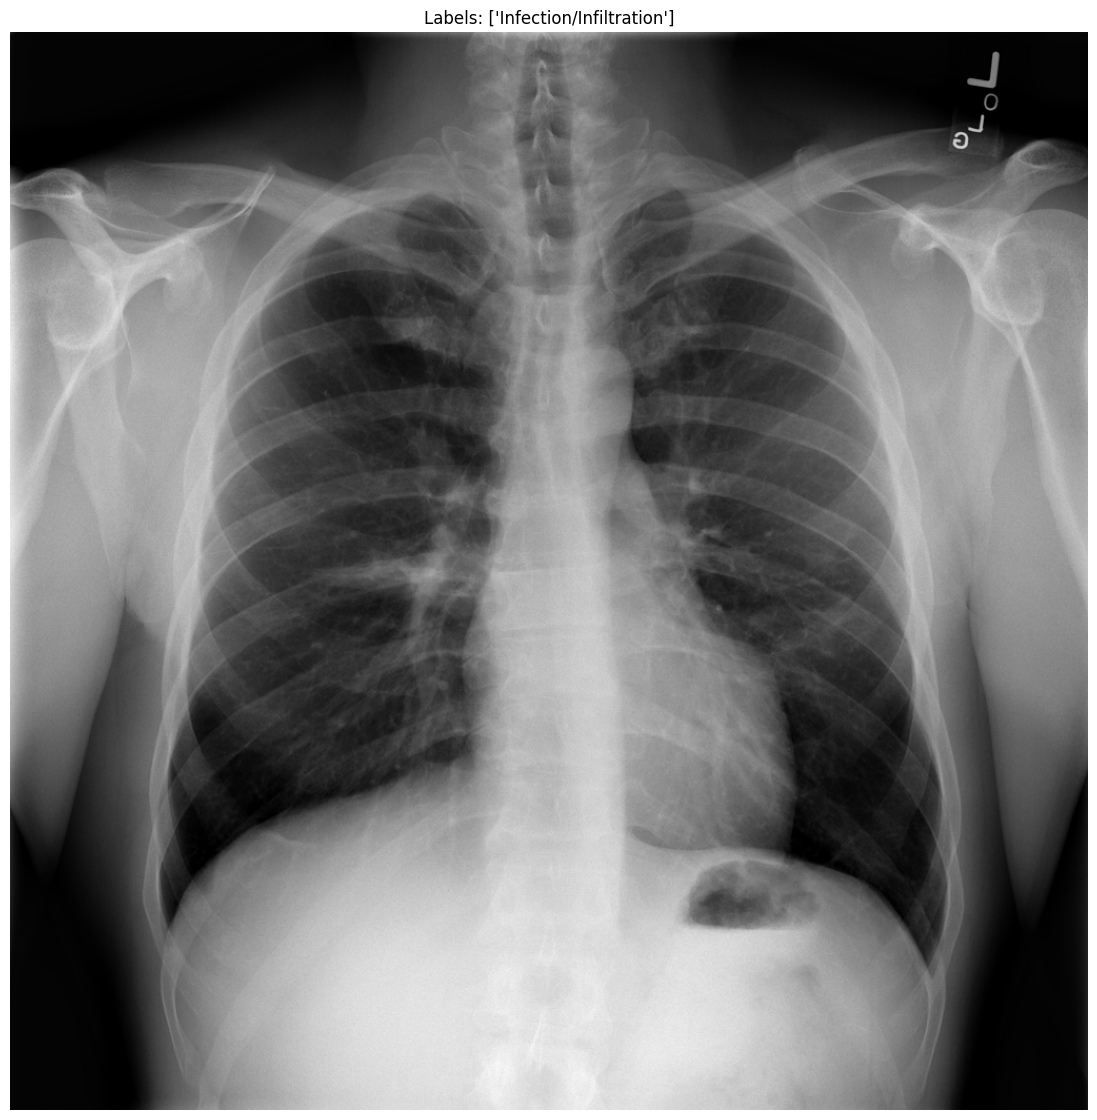

Image shape: (1024, 1024, 3)


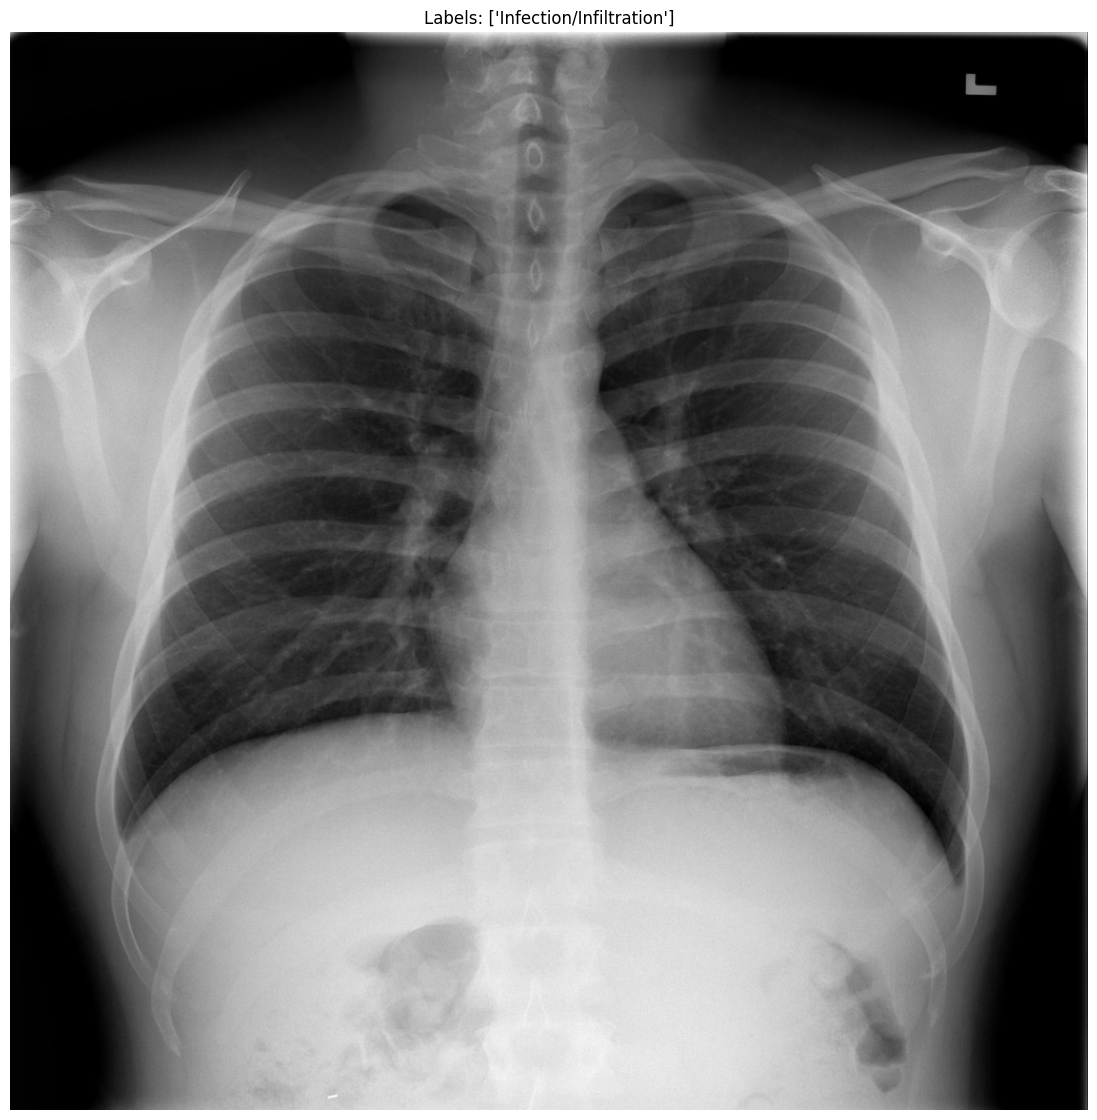

Image shape: (1024, 1024, 3)


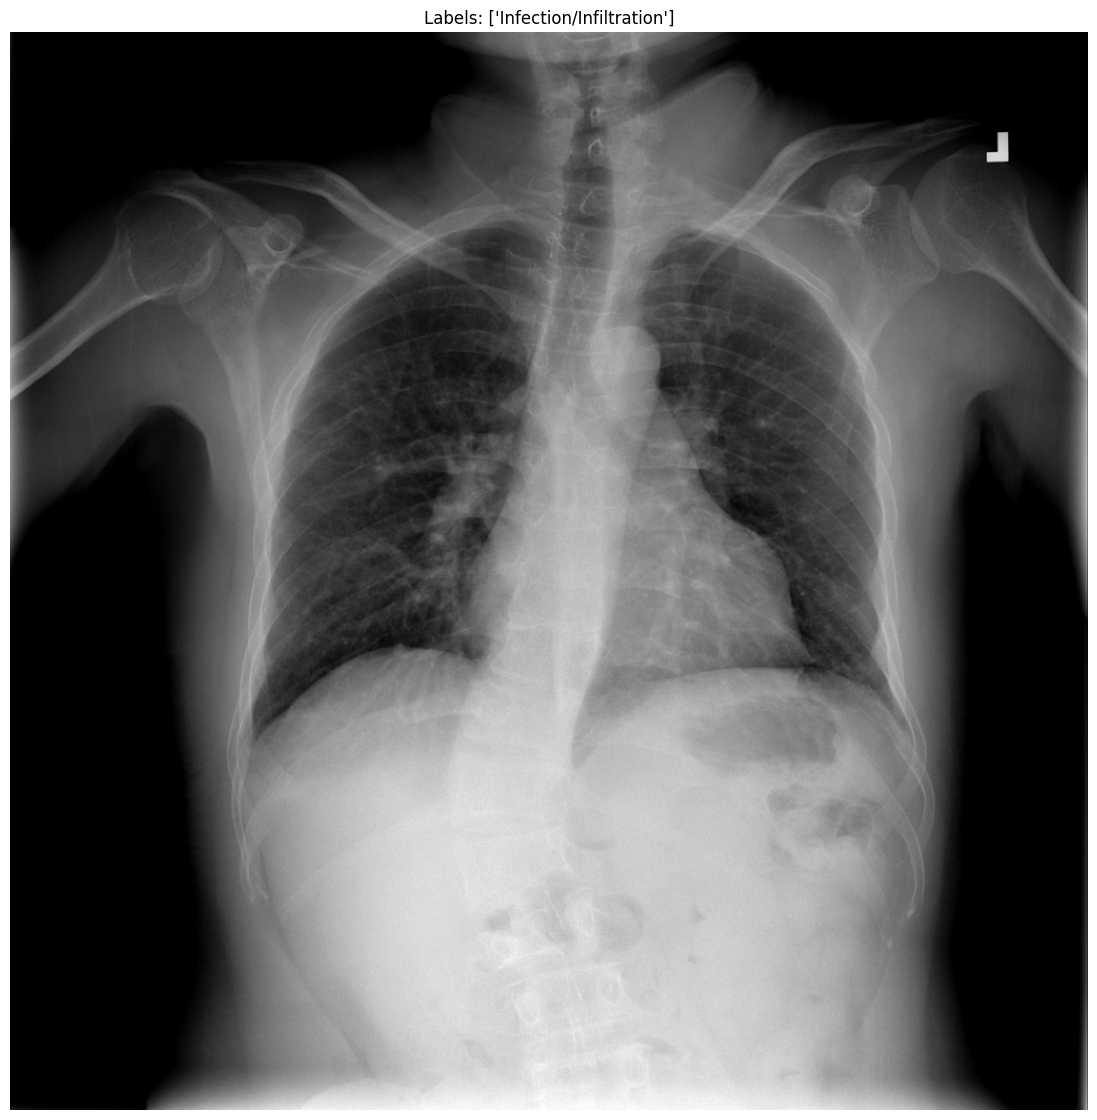

Image shape: (1024, 1024, 3)


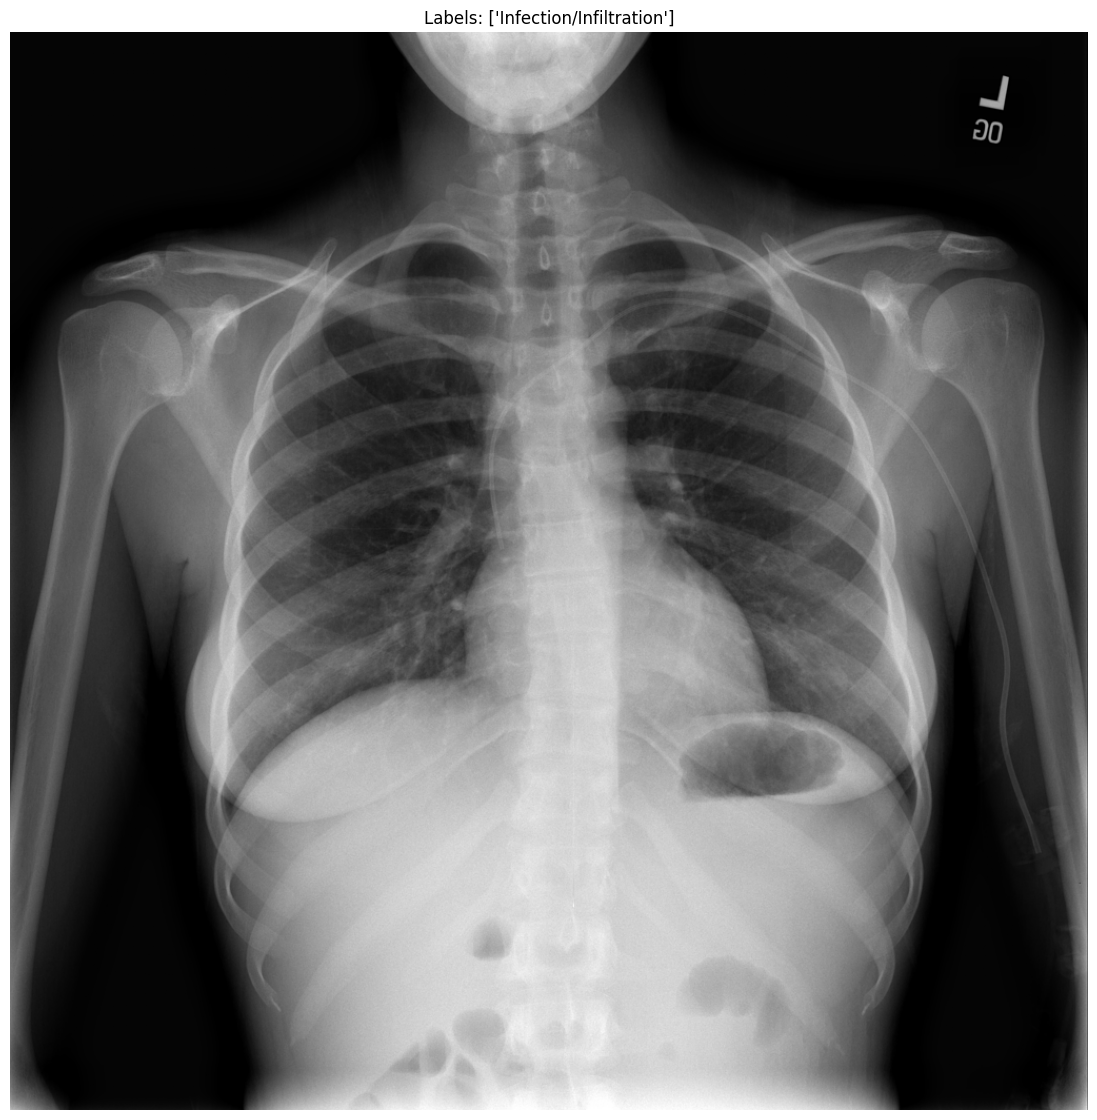

Image shape: (1024, 1024, 3)


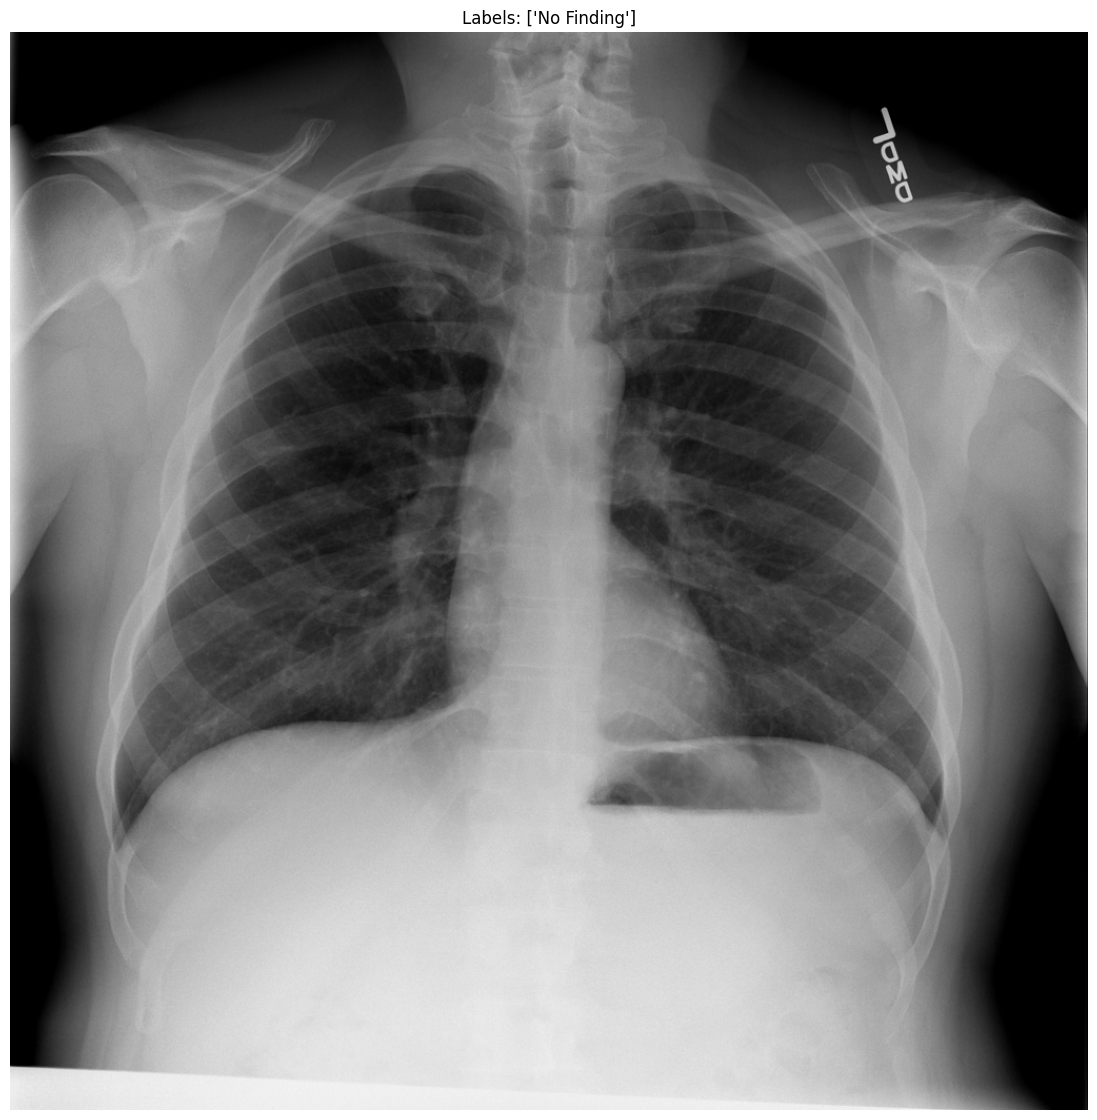

Image shape: (1024, 1024, 3)


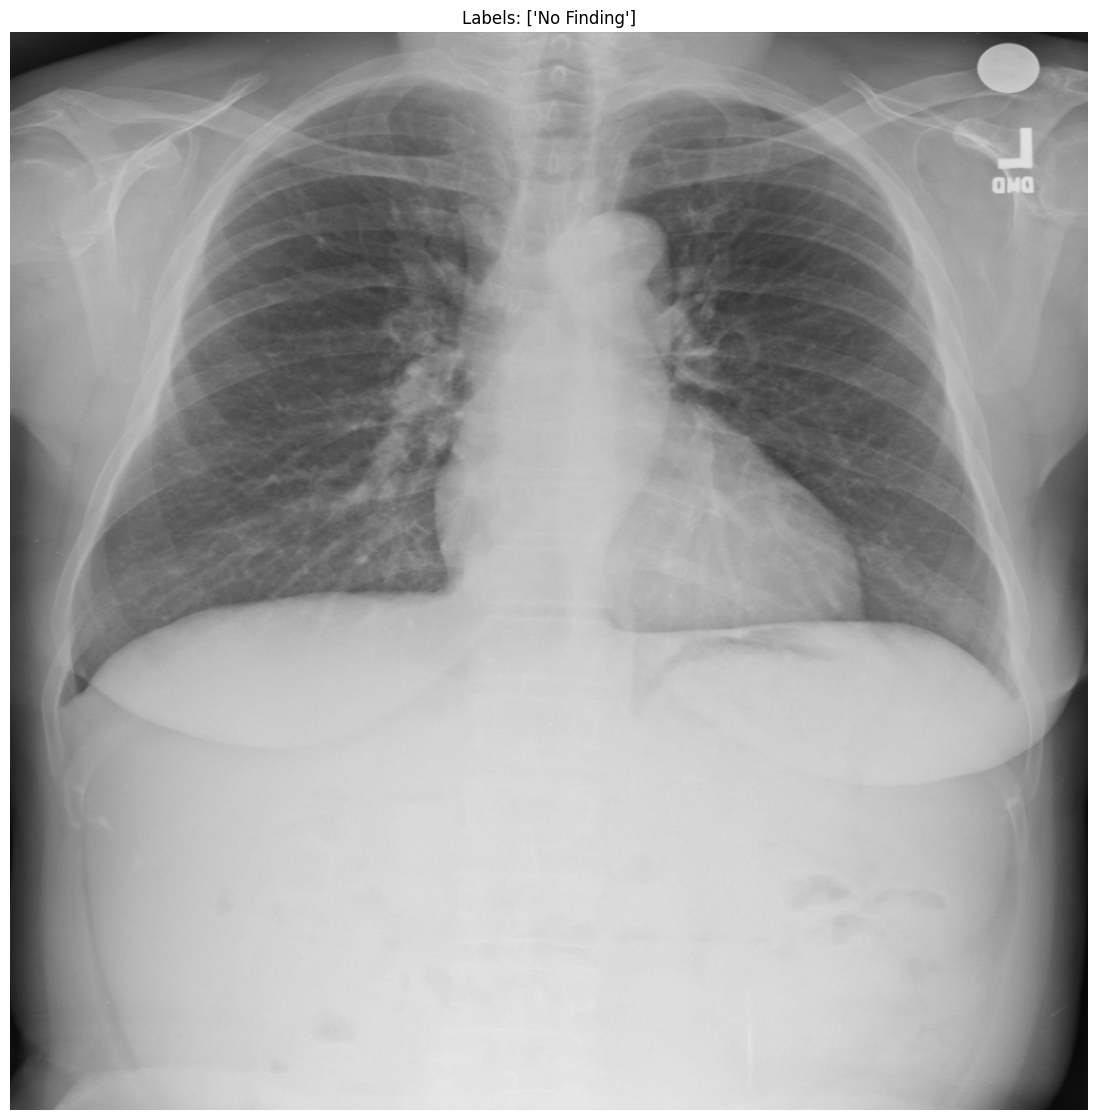

Image shape: (1024, 1024, 3)


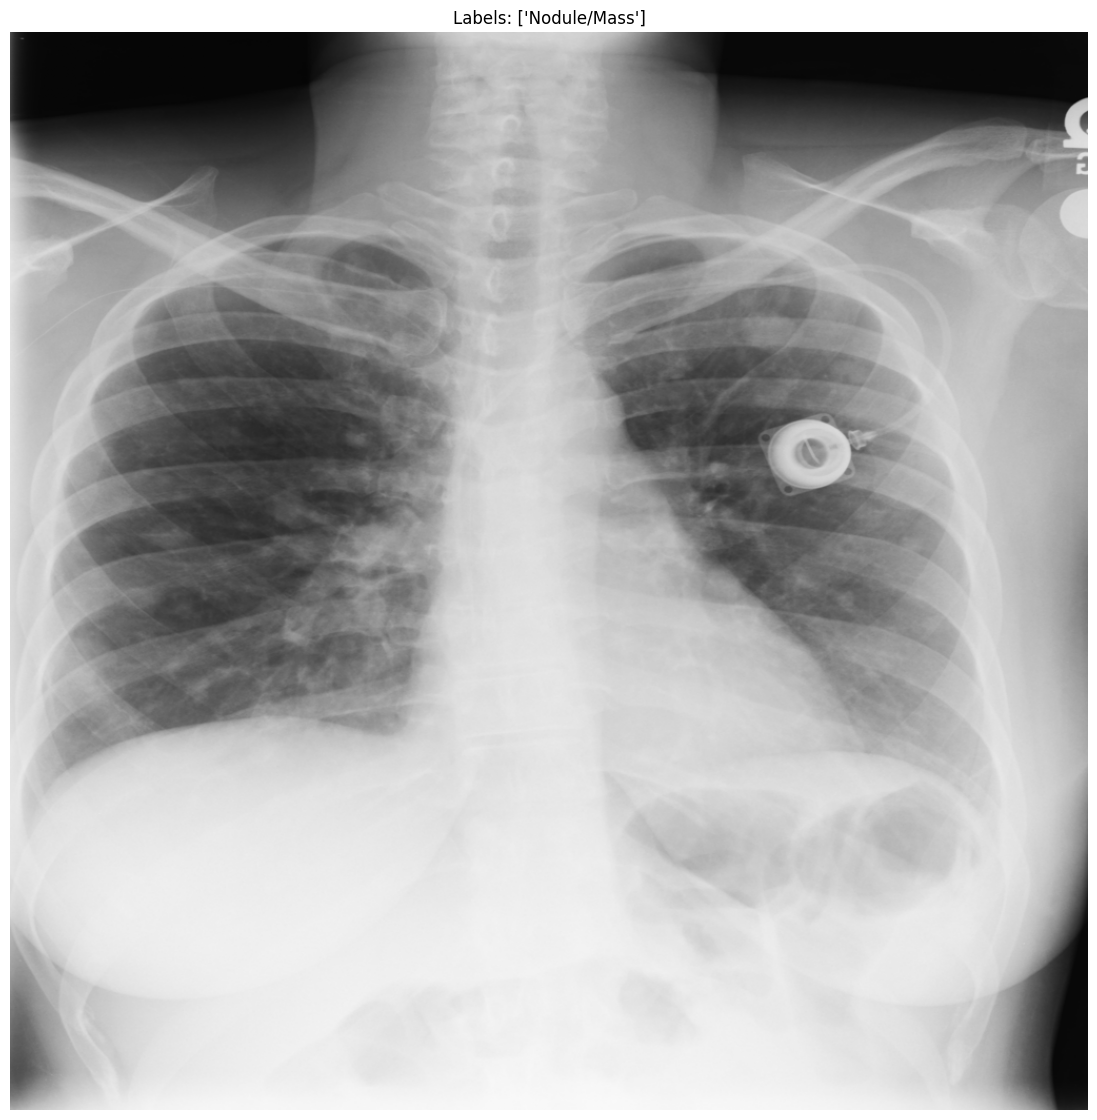

Image shape: (1024, 1024, 3)


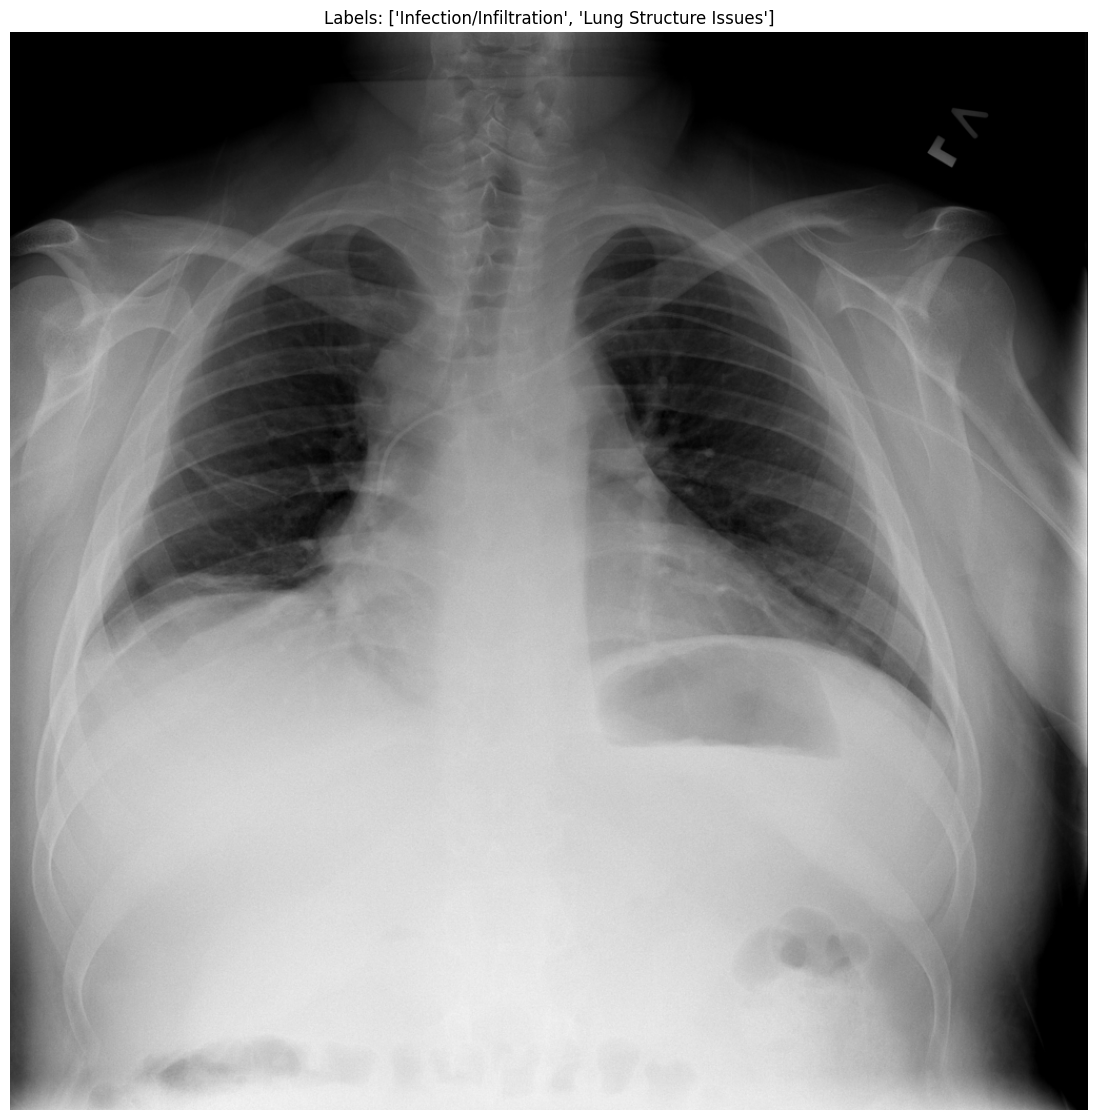

Image shape: (1024, 1024, 3)


In [ ]:
import matplotlib.pyplot as plt

# Grab one batch from the dataset
for images, labels in test_dataset.take(1):
    for i in range(len(images)):
        img = images[i].numpy()
        label = labels[i].numpy()

        # Optional: apply your label decoding if available
        if isinstance(label[0], np.float32) or isinstance(label[0], float):
            label_names = [all_labels[j] for j, v in enumerate(label) if v > 0.5]
        else:
            label_names = label  # fallback

        plt.figure(figsize=(14, 14))  # width x height in inches
        plt.imshow(img)
        plt.title(f"Labels: {label_names}")
        plt.axis('off')
        plt.show()
        print(f"Image shape: {img.shape}")

In [ ]:
# Check alignment manually from your source DataFrame
print(train_df.iloc[0]['Image Index'])
print(train_df.iloc[0]['encoded_labels'])

00018942_001.png
[0, 1, 0, 1, 1, 0, 1]


## Fine-Tuning EfficientNet

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import BinaryAccuracy

import tensorflow.keras.backend as K
import tensorflow as tf

# Focal Loss (same as yours)
# def focal_loss(gamma=2., alpha=0.85):
#     def focal_loss_fixed(y_true, y_pred):
#         bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
#         pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
#         return alpha * tf.pow(1. - pt, gamma) * bce
#     return focal_loss_fixed

from sklearn.utils.class_weight import compute_class_weight

# compute_class_weight returns weights for 0/1 binary classes
# You want positive class frequency for each class
positive_weights = (df['encoded_labels'].tolist())
positive_weights = np.mean(np.array(positive_weights), axis=0)
# alpha_vector = 1.0 - positive_weights  # higher weight for rare classes
alpha_vector = (1.0 - positive_weights) ** 1.5  # Amplify the rare classes

def focal_loss(gamma=3., alpha=alpha_vector):
    def focal_loss_fixed(y_true, y_pred):
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        return alpha_t * tf.pow(1. - pt, gamma) * bce
    return focal_loss_fixed

NUM_CLASSES = 7  # Number of classes

# Load base model without the top layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Initially freeze the base_model

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
outputs = Dense(NUM_CLASSES, activation='sigmoid')(x)
model = Model(inputs, outputs)
model.summary()

# Unfreeze last N layers of the base model
for layer in base_model.layers:#[-200:]:  # Try unfreezing the last 20 layers
    layer.trainable = True

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1024, 1024, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 32, 32, 1280)   │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
### --- Phase 1: BCE Warm-up --- ###
checkpoint = ModelCheckpoint(
    "binary_model.weights.h5",
    monitor="val_binary_accuracy",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    verbose=1
)

print("Phase 1: Warm-up with Binary Crossentropy")

model.compile(
    optimizer=Adam(3e-6),
    loss="binary_crossentropy",
    metrics=[BinaryAccuracy()]
)

history1 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    callbacks=[checkpoint]
)

Phase 1: Warm-up with Binary Crossentropy
Epoch 1/3
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - binary_accuracy: 0.7405 - loss: 0.5496
Epoch 1: val_binary_accuracy improved from -inf to 0.81561, saving model to binary_model.weights.h5
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 793s 193ms/step - binary_accuracy: 0.7405 - loss: 0.5496 - val_binary_accuracy: 0.8156 - val_loss: 0.4482
Epoch 2/3
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - binary_accuracy: 0.8153 - loss: 0.4238
Epoch 2: val_binary_accuracy did not improve from 0.81561
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 587s 169ms/step - binary_accuracy: 0.8153 - loss: 0.4238 - val_binary_accuracy: 0.8147 - val_loss: 0.4776
Epoch 3/3
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - binary_accuracy: 0.8152 - loss: 0.4154
Epoch 3: val_binary_accuracy did not improve from 0.81561
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 586s 169ms/step - binary_accuracy: 0.8152 - loss: 0.4154 - val_binary_accuracy: 0.6893 - val_loss: 0.6255


In [ ]:
### --- Phase 2: Switch to Focal Loss --- ###
checkpoint_2 = ModelCheckpoint(
    "best_model.weights.h5",
    monitor="val_binary_accuracy",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    verbose=1
)

print("Phase 2: Fine-tune with Focal Loss")

model.compile(
    optimizer=Adam(3e-6),
    loss=focal_loss(),
    metrics=[BinaryAccuracy()]
)

history2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[checkpoint_2]
)

# Combine histories
history = {}
for key in history1.history.keys():
    history[key] = history1.history[key] + history2.history[key]

Phase 2: Fine-tune with Focal Loss
Epoch 1/15
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - binary_accuracy: 0.7827 - loss: 0.0453
Epoch 1: val_binary_accuracy improved from -inf to 0.77104, saving model to best_model.weights.h5
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 700s 182ms/step - binary_accuracy: 0.7827 - loss: 0.0453 - val_binary_accuracy: 0.7710 - val_loss: 0.0267
Epoch 2/15
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - binary_accuracy: 0.7370 - loss: 0.0261
Epoch 2: val_binary_accuracy did not improve from 0.77104
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 591s 170ms/step - binary_accuracy: 0.7370 - loss: 0.0261 - val_binary_accuracy: 0.6357 - val_loss: 0.0288
Epoch 3/15
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - binary_accuracy: 0.7550 - loss: 0.0254
Epoch 3: val_binary_accuracy did not improve from 0.77104
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 591s 170ms/step - binary_accuracy: 0.7550 - loss: 0.0254 - val_binary_accuracy: 0.6458 - val_loss: 0.0289
Epoch 4/15
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 0s 150m

## Manually Test Predictions on Test Data


In [ ]:
# Grab a batch from the test dataset
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)

    # Print the first 5 predictions vs actual labels
    for i in range(8):
        print(f"Actual:     {labels[i].numpy().round(2)}")
        print(f"Predicted:  {predictions[i].round(2)}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Actual:     [0. 0. 0. 0. 0. 1. 0.]
Predicted:  [0.46 0.53 0.43 0.43 0.43 0.51 0.43]

Actual:     [0. 0. 0. 0. 0. 0. 1.]
Predicted:  [0.47 0.47 0.45 0.46 0.41 0.52 0.41]

Actual:     [0. 0. 0. 1. 0. 0. 0.]
Predicted:  [0.54 0.48 0.55 0.46 0.43 0.52 0.39]

Actual:     [0. 0. 0. 0. 0. 0. 1.]
Predicted:  [0.41 0.5  0.38 0.46 0.46 0.47 0.42]

Actual:     [0. 0. 0. 0. 1. 0. 0.]
Predicted:  [0.42 0.57 0.4  0.45 0.48 0.46 0.41]

Actual:     [0. 0. 0. 1. 0. 0. 0.]
Predicted:  [0.49 0.54 0.48 0.48 0.54 0.47 0.34]

Actual:     [0. 1. 0. 1. 1. 0. 0.]
Predicted:  [0.55 0.49 0.44 0.42 0.45 0.47 0.39]

Actual:     [0. 0. 0. 0. 0. 1. 0.]
Predicted:  [0.53 0.49 0.54 0.43 0.52 0.5  0.37]



## Plot Training Curves (Accuracy/Loss)

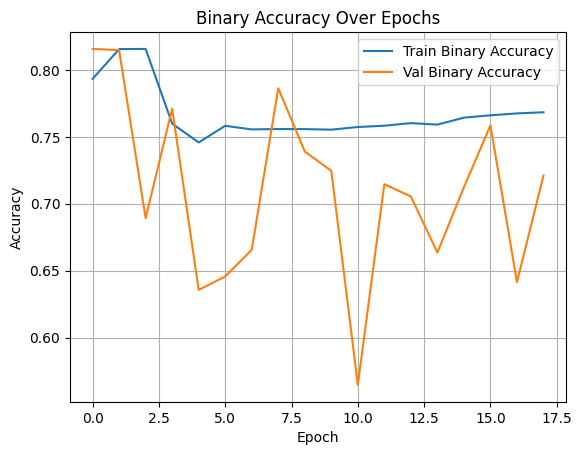

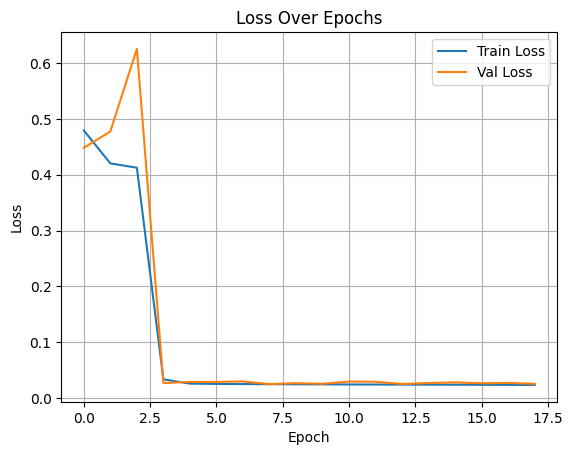

In [ ]:
import matplotlib.pyplot as plt

# Plot binary accuracy
plt.plot(history['binary_accuracy'], label='Train Binary Accuracy')
plt.plot(history['val_binary_accuracy'], label='Val Binary Accuracy')
plt.title('Binary Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot loss
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## Evaluate on Test Set

In [2]:
test_loss, test_binary_accuracy = model.evaluate(test_dataset)
print(f"\nTest Binary Accuracy: {test_binary_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

## Per-Class Performance (Precision/Recall)


In [ ]:
from sklearn.metrics import classification_report
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = np.vstack([y for _, y in test_dataset])
print(classification_report(y_true, y_pred, target_names=all_labels))

476/476 ━━━━━━━━━━━━━━━━━━━━ 54s 93ms/step
                        precision    recall  f1-score   support

        Cardiac Issues       0.04      0.34      0.07       155
  Fluid Related Issues       0.23      0.54      0.32       881
                Hernia       0.01      0.24      0.02        21
Infection/Infiltration       0.31      0.05      0.09      1062
 Lung Structure Issues       0.27      0.28      0.27      1066
            No Finding       0.27      0.36      0.31      1015
           Nodule/Mass       0.15      0.01      0.02       727

             micro avg       0.19      0.26      0.22      4927
             macro avg       0.18      0.26      0.16      4927
          weighted avg       0.25      0.26      0.21      4927
           samples avg       0.20      0.26      0.21      4927



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Grab a batch from the test dataset
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)

    # Print the first 5 predictions vs actual labels
    for i in range(8):
        print(f"Actual:     {labels[i].numpy().round(2)}")
        print(f"Predicted:  {predictions[i].round(2)}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Actual:     [0. 0. 0. 0. 1. 0. 0.]
Predicted:  [0.57 0.49 0.5  0.49 0.53 0.56 0.36]

Actual:     [0. 0. 0. 0. 0. 1. 0.]
Predicted:  [0.43 0.24 0.31 0.54 0.32 0.72 0.33]

Actual:     [0. 0. 0. 1. 0. 0. 0.]
Predicted:  [0.41 0.3  0.37 0.52 0.34 0.73 0.35]

Actual:     [0. 1. 0. 0. 0. 0. 0.]
Predicted:  [0.53 0.5  0.46 0.51 0.48 0.6  0.36]

Actual:     [0. 1. 0. 0. 0. 0. 0.]
Predicted:  [0.56 0.54 0.47 0.51 0.52 0.55 0.36]

Actual:     [0. 0. 0. 0. 0. 0. 1.]
Predicted:  [0.56 0.65 0.44 0.48 0.58 0.46 0.37]

Actual:     [0. 1. 0. 0. 1. 0. 0.]
Predicted:  [0.59 0.73 0.54 0.46 0.53 0.48 0.39]

Actual:     [0. 1. 0. 1. 0. 0. 0.]
Predicted:  [0.49 0.73 0.46 0.55 0.6  0.39 0.41]



In [ ]:
# Re-compile with slightly lower gamma and same alpha
model.compile(
    optimizer=Adam(2e-6),
    loss=focal_loss(gamma=1.5),
    metrics=[BinaryAccuracy()]
)

# Run 2–3 more epochs
history_more = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[checkpoint3]
)

Epoch 1/5
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - binary_accuracy: 0.7032 - loss: 0.0589
Epoch 1: val_binary_accuracy did not improve from 0.81031
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 708s 183ms/step - binary_accuracy: 0.7032 - loss: 0.0589 - val_binary_accuracy: 0.7470 - val_loss: 0.0639
Epoch 2/5
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - binary_accuracy: 0.7046 - loss: 0.0586
Epoch 2: val_binary_accuracy did not improve from 0.81031
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 596s 171ms/step - binary_accuracy: 0.7046 - loss: 0.0586 - val_binary_accuracy: 0.6520 - val_loss: 0.0603
Epoch 3/5
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - binary_accuracy: 0.7040 - loss: 0.0584
Epoch 3: val_binary_accuracy did not improve from 0.81031
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 596s 172ms/step - binary_accuracy: 0.7040 - loss: 0.0584 - val_binary_accuracy: 0.7022 - val_loss: 0.0597
Epoch 4/5
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - binary_accuracy: 0.7056 - loss: 0.0582
Epoch 4: val_binary_accuracy di

In [ ]:
# Grab a batch from the test dataset
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)

    # Print the first 5 predictions vs actual labels
    for i in range(8):
        print(f"Actual:     {labels[i].numpy().round(2)}")
        print(f"Predicted:  {predictions[i].round(2)}\n")

from sklearn.metrics import classification_report
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = np.vstack([y for _, y in test_dataset])
print(classification_report(y_true, y_pred, target_names=all_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Actual:     [0. 0. 0. 0. 1. 0. 0.]
Predicted:  [0.23 0.24 0.38 0.5  0.46 0.62 0.43]

Actual:     [0. 0. 0. 0. 1. 0. 1.]
Predicted:  [0.23 0.34 0.32 0.46 0.71 0.44 0.37]

Actual:     [0. 0. 0. 0. 0. 1. 0.]
Predicted:  [0.45 0.36 0.4  0.45 0.41 0.59 0.36]

Actual:     [0. 0. 0. 0. 0. 0. 1.]
Predicted:  [0.44 0.45 0.35 0.54 0.44 0.53 0.3 ]

Actual:     [0. 1. 0. 0. 1. 0. 0.]
Predicted:  [0.19 0.61 0.31 0.41 0.65 0.39 0.53]

Actual:     [0. 1. 0. 0. 1. 0. 0.]
Predicted:  [0.51 0.77 0.58 0.41 0.59 0.35 0.45]

Actual:     [0. 1. 0. 0. 0. 0. 0.]
Predicted:  [0.29 0.55 0.42 0.44 0.49 0.52 0.37]

Actual:     [0. 0. 0. 0. 0. 1. 0.]
Predicted:  [0.1  0.12 0.12 0.56 0.14 0.8  0.26]

476/476 ━━━━━━━━━━━━━━━━━━━━ 50s 84ms/step
                        precision    recall  f1-score   support

        Cardiac Issues       0.01      0.01      0.01       155
  Fluid Related Issues       0.26      0.26      0.26       881
                Hernia       0.01      0.05     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Hyper Parameter Tuning and Testing on Yet More Epochs

In [ ]:
# Check label distribution on test set only
from collections import Counter
import numpy as np

test_labels = np.concatenate([y for _, y in test_dataset], axis=0)
label_sums = np.sum(test_labels, axis=0)
print("Test set label counts:", label_sums)

Test set label counts: [ 155.  881.   21. 1062. 1066. 1015.  727.]


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import BinaryAccuracy

import tensorflow.keras.backend as K
import tensorflow as tf

# # def penalized_binary_crossentropy(y_true, y_pred):
# #     bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
# #     max_pred = K.max(y_pred, axis=1)
# #     # penalty = K.cast(K.less(max_pred, 0.5), K.floatx()) * 1.0  # penalty of 1.0 if all predictions < 0.5
# #     # penalty = 0.1 + 0.3 * (1 - K.mean(max_pred))  # more penalty if confidence is really low
# #     confidence = K.max(y_pred, axis=1)
# #     penalty = K.maximum(0.0, 0.5 - confidence)  # Linearly stronger as confidence gets lower
# #     return bce + penalty

def focal_loss(gamma=2., alpha=0.8):
    def focal_loss_fixed(y_true, y_pred):
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return alpha * tf.pow(1. - pt, gamma) * bce
    return focal_loss_fixed

# NUM_CLASSES = 7  # Number of classes

# # Load base model without the top layer
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
# base_model.trainable = False  # Initially freeze the base_model

# inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# x = base_model(inputs, training=False)
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.4)(x)
# outputs = Dense(NUM_CLASSES, activation='sigmoid')(x)
# model = Model(inputs, outputs)

# # Unfreeze last N layers of the base model
# for layer in base_model.layers:#[-200:]:  # Try unfreezing the last 20 layers
#     layer.trainable = True

# # model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Use lower LR for fine-tuning
# #               loss='binary_crossentropy',
# #               metrics=[tf.keras.metrics.BinaryAccuracy()])

# # model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=penalized_binary_crossentropy, metrics=[BinaryAccuracy()])

model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-6),
    loss=focal_loss(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1024, 1024, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 32, 32, 1280)   │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 4,016,515 (15.32 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
# Grab a batch from the test dataset
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)

    # Print the first 5 predictions vs actual labels
    for i in range(8):
        print(f"Actual:     {labels[i].numpy().round(2)}")
        print(f"Predicted:  {predictions[i].round(2)}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Actual:     [0. 0. 0. 0. 1. 0. 0.]
Predicted:  [0.14 0.46 0.13 0.46 0.5  0.52 0.25]

Actual:     [0. 0. 0. 0. 1. 0. 0.]
Predicted:  [0.17 0.49 0.14 0.39 0.43 0.54 0.26]

Actual:     [0. 0. 0. 0. 0. 0. 1.]
Predicted:  [0.2  0.46 0.13 0.43 0.42 0.62 0.28]

Actual:     [0. 1. 0. 0. 0. 0. 1.]
Predicted:  [0.22 0.52 0.21 0.45 0.4  0.52 0.34]

Actual:     [0. 0. 0. 1. 0. 0. 1.]
Predicted:  [0.2  0.24 0.06 0.38 0.3  0.54 0.33]

Actual:     [0. 0. 0. 0. 1. 0. 1.]
Predicted:  [0.28 0.33 0.13 0.42 0.42 0.46 0.32]

Actual:     [0. 0. 0. 1. 0. 0. 0.]
Predicted:  [0.19 0.18 0.05 0.48 0.25 0.61 0.3 ]

Actual:     [0. 0. 0. 1. 0. 0. 1.]
Predicted:  [0.1  0.39 0.1  0.48 0.42 0.57 0.3 ]



In [ ]:
from sklearn.metrics import classification_report
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = np.vstack([y for _, y in test_dataset])
print(classification_report(y_true, y_pred, target_names=all_labels))

476/476 ━━━━━━━━━━━━━━━━━━━━ 50s 84ms/step
                        precision    recall  f1-score   support

        Cardiac Issues       0.00      0.00      0.00       155
  Fluid Related Issues       0.18      0.01      0.02       881
                Hernia       0.00      0.00      0.00        21
Infection/Infiltration       0.23      0.05      0.08      1062
 Lung Structure Issues       0.29      0.06      0.10      1066
            No Finding       0.28      0.78      0.41      1015
           Nodule/Mass       0.29      0.00      0.01       727

             micro avg       0.28      0.19      0.22      4927
             macro avg       0.18      0.13      0.09      4927
          weighted avg       0.24      0.19      0.13      4927
           samples avg       0.23      0.23      0.23      4927



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Final Training Round


After exploring hyperparameter options we realized a few things were true, GAMMA = 2.0 and ALPHA = 0.8 for the final round of training. These values were chosen to strike a balance between penalizing easy negatives and amplifying the contribution of underrepresented positive cases, particularly for rare classes like Hernia and Cardiac Issues. The focal loss formulation with these settings helped the model escape a local minimum where it previously defaulted to predicting mostly negatives.

We also unfreezed the full EfficientNetB0 backbone during this phase to allow fine-tuning on domain-specific features, while a small dense layer with Dropout(0.3) before the output helped mitigate overfitting. Basic data augmentation (horizontal flips, brightness, and contrast jitter) was applied only to the training data to improve generalization.

## Final EfficientNet Fine-Tuning Architecture

In [ ]:
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import BinaryAccuracy
import tensorflow.keras.backend as K

# === Constants ===
IMG_SIZE = 1024
BATCH_SIZE = 8
NUM_CLASSES = 7
LEARNING_RATE = 2e-6
IMAGE_PATH = '/content/chest_xray_images/images_resized'
GAMMA_FIXED = 2.0
ALPHA_FIXED = 0.8  # Can tune later

# === Data Prep ===
def _load_image(filename):
    path = os.path.join(IMAGE_PATH, filename.numpy().decode('utf-8'))
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def _parse(filename, label, augment=False):
    image = tf.py_function(_load_image, [filename], tf.float32)
    image.set_shape([IMG_SIZE, IMG_SIZE, 3])
    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=1.0, upper=1.2)
    return image, label

def build_dataset(df, augment=False):
    filenames = df['Image Index'].values
    labels = np.array(df['encoded_labels'].tolist(), dtype=np.float32)
    ds = tf.data.Dataset.from_tensor_slices((filenames, labels))
    ds = ds.map(lambda x, y: _parse(x, y, augment), num_parallel_calls=tf.data.AUTOTUNE)
    if augment: ds = ds.shuffle(1000)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# === Train/Test/Val Split ===
trainval_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(trainval_df, test_size=0.2, random_state=42)

train_dataset = build_dataset(train_df, augment=True)
val_dataset = build_dataset(val_df)
test_dataset = build_dataset(test_df)

# === Focal Loss ===
def focal_loss(gamma=GAMMA_FIXED, alpha=ALPHA_FIXED):
    def loss_fn(y_true, y_pred):
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return alpha * tf.pow(1. - pt, gamma) * bce
    return loss_fn

# === Model Architecture ===
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1024, 1024, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 32, 32, 1280)   │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,442 (16.08 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Train and Save to Checkpoints

In [ ]:
# === Checkpoint ===
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/best_model_final.weights.h5",
    monitor="val_binary_accuracy",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    verbose=1
)

# === Phase 1: BCE Warm-up with Label Smoothing ===
print("Phase 1: BCE with label smoothing")
model.compile(
    optimizer=Adam(LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
    metrics=[BinaryAccuracy()]
)
history1 = model.fit(train_dataset, validation_data=val_dataset, epochs=1, callbacks=[checkpoint])

# === Unfreeze Backbone ===
for layer in base_model.layers:
    layer.trainable = True

# === Phase 2: Fine-tune with Focal Loss ===
print("Phase 2: Focal Loss")
model.compile(
    optimizer=Adam(LEARNING_RATE),
    loss=focal_loss(),
    metrics=[BinaryAccuracy()]
)
history2 = model.fit(train_dataset, validation_data=val_dataset, epochs=30, callbacks=[checkpoint])

# === Combine Histories ===
combined_history = {}
for key in history1.history:
    combined_history[key] = history1.history[key] + history2.history[key]

Phase 1: BCE with label smoothing
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - binary_accuracy: 0.7231 - loss: 0.6107
Epoch 1: val_binary_accuracy improved from -inf to 0.81561, saving model to /content/drive/MyDrive/best_model_final.weights.h5
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 417s 107ms/step - binary_accuracy: 0.7232 - loss: 0.6107 - val_binary_accuracy: 0.8156 - val_loss: 0.4902
Phase 2: Focal Loss
Epoch 1/30
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - binary_accuracy: 0.6671 - loss: 0.1251
Epoch 1: val_binary_accuracy did not improve from 0.81561
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 748s 185ms/step - binary_accuracy: 0.6671 - loss: 0.1251 - val_binary_accuracy: 0.8156 - val_loss: 0.0907
Epoch 2/30
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - binary_accuracy: 0.7988 - loss: 0.0951
Epoch 2: val_binary_accuracy did not improve from 0.81561
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 574s 166ms/step - binary_accuracy: 0.7988 - loss: 0.0951 - val_binary_accuracy: 0.7905 - val_loss: 0.0957
Epoch 3/30
34

In [ ]:
model.load_weights("/content/drive/MyDrive/best_model_final.weights.h5")

## Evaluate:

In [ ]:
import matplotlib.pyplot as plt

# Grab a batch from the test dataset
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)

    # Print the first 5 predictions vs actual labels
    for i in range(8):
        print(f"Actual:     {labels[i].numpy().round(2)}")
        print(f"Predicted:  {predictions[i].round(2)}\n")

from sklearn.metrics import classification_report
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = np.vstack([y for _, y in test_dataset])
print(classification_report(y_true, y_pred, target_names=all_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step
Actual:     [0. 0. 0. 0. 0. 1. 0.]
Predicted:  [0.26 0.28 0.16 0.43 0.39 0.44 0.29]

Actual:     [0. 0. 0. 0. 0. 1. 0.]
Predicted:  [0.18 0.29 0.12 0.36 0.66 0.27 0.37]

Actual:     [0. 0. 0. 0. 0. 1. 0.]
Predicted:  [0.29 0.29 0.18 0.44 0.41 0.41 0.3 ]

Actual:     [0. 0. 0. 0. 0. 0. 1.]
Predicted:  [0.24 0.44 0.11 0.34 0.35 0.38 0.4 ]

Actual:     [0. 0. 0. 0. 0. 1. 0.]
Predicted:  [0.22 0.23 0.14 0.45 0.27 0.52 0.27]

Actual:     [0. 0. 0. 0. 0. 0. 1.]
Predicted:  [0.17 0.29 0.11 0.38 0.32 0.41 0.53]

Actual:     [1. 0. 0. 0. 0. 0. 0.]
Predicted:  [0.4  0.37 0.17 0.41 0.3  0.38 0.41]

Actual:     [0. 1. 0. 0. 1. 0. 0.]
Predicted:  [0.26 0.63 0.14 0.41 0.36 0.31 0.41]

476/476 ━━━━━━━━━━━━━━━━━━━━ 43s 76ms/step
                        precision    recall  f1-score   support

        Cardiac Issues       1.00      0.01      0.01       155
  Fluid Related Issues       0.69      0.50      0.58       881
                Hernia       0.00      0.00   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

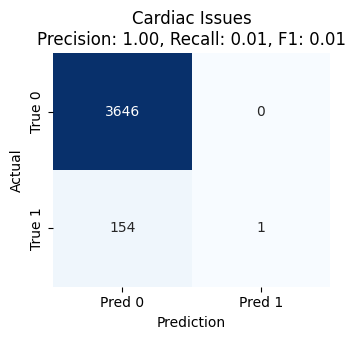

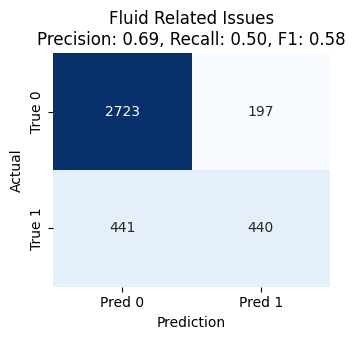

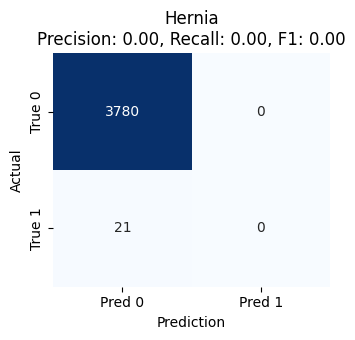

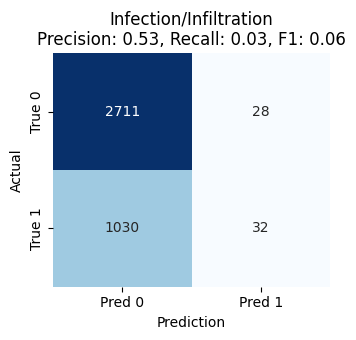

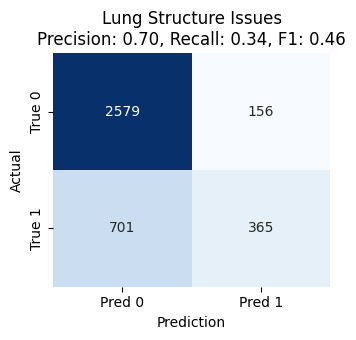

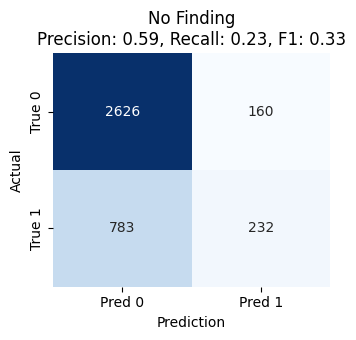

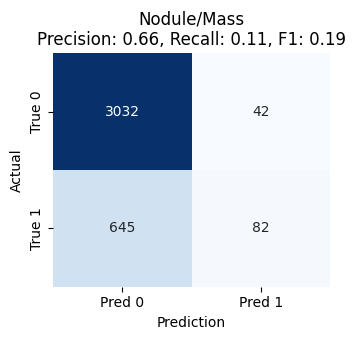

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict on test set
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int))  # threshold at 0.5

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Class names
class_names = [
    "Cardiac Issues",
    "Fluid Related Issues",
    "Hernia",
    "Infection/Infiltration",
    "Lung Structure Issues",
    "No Finding",
    "Nodule/Mass"
]

# Confusion matrices and metrics
cm = multilabel_confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
recall = recall_score(y_true, y_pred, average=None, zero_division=0)
f1 = f1_score(y_true, y_pred, average=None, zero_division=0)

# Plot each matrix with metrics
for i in range(len(class_names)):
    plt.figure(figsize=(3.5, 3.5))
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'])
    plt.title(f"{class_names[i]}\nPrecision: {precision[i]:.2f}, Recall: {recall[i]:.2f}, F1: {f1[i]:.2f}")
    plt.xlabel("Prediction")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

## Final Training Phases 3-5

After training for 30 epochs it was clear that additional epochs could conitune to raise our metrics

### Phase 3

In [ ]:
from tensorflow.keras.metrics import Recall

# === Checkpoint ===
checkpoint3 = ModelCheckpoint(
    "/content/drive/MyDrive/best_model_final3.weights.h5",
    monitor="val_binary_accuracy",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    verbose=1
)

# === Phase 3: Fine-tune with Focal Loss ===
print("Phase 3: Focal Loss")
model.compile(
    optimizer=Adam(1e-6),
    loss=focal_loss(gamma=1.5, alpha=ALPHA_FIXED),
    metrics=[BinaryAccuracy(), Recall()]
)
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[checkpoint3])

Phase 3: Focal Loss
Epoch 1/10
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - binary_accuracy: 0.8289 - loss: 0.1111 - recall: 0.2347
Epoch 1: val_binary_accuracy improved from -inf to 0.83405, saving model to /content/drive/MyDrive/best_model_final3.weights.h5
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 399s 108ms/step - binary_accuracy: 0.8289 - loss: 0.1111 - recall: 0.2347 - val_binary_accuracy: 0.8341 - val_loss: 0.1065 - val_recall: 0.1974
Epoch 2/10
3420/3421 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - binary_accuracy: 0.8289 - loss: 0.1104 - recall: 0.2153
Epoch 2: val_binary_accuracy did not improve from 0.83405
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 335s 96ms/step - binary_accuracy: 0.8289 - loss: 0.1104 - recall: 0.2153 - val_binary_accuracy: 0.8339 - val_loss: 0.1062 - val_recall: 0.1970
Epoch 3/10
3420/3421 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - binary_accuracy: 0.8289 - loss: 0.1102 - recall: 0.2197
Epoch 3: val_binary_accuracy did not improve from 0.83405
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 335s 96ms/step - 

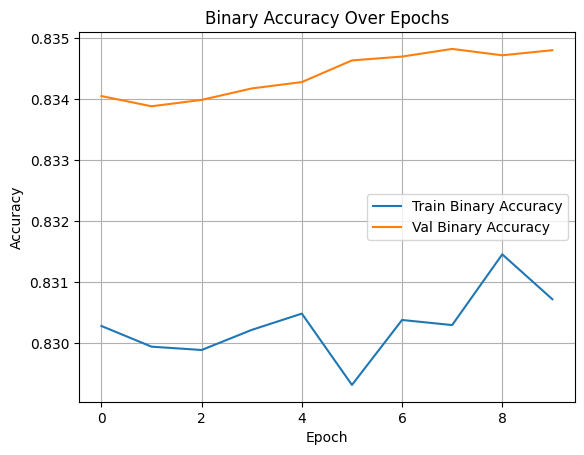

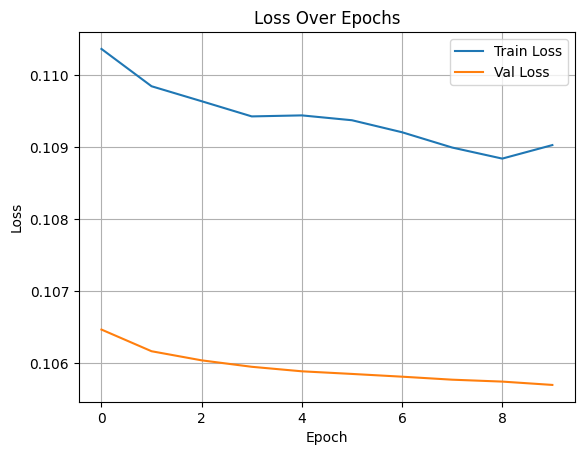

In [ ]:
import matplotlib.pyplot as plt

h = history.history

history = h.copy()

# Plot binary accuracy
plt.plot(history['binary_accuracy'], label='Train Binary Accuracy')
plt.plot(history['val_binary_accuracy'], label='Val Binary Accuracy')
plt.title('Binary Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot loss
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Grab a batch from the test dataset
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)

    # Print the first 5 predictions vs actual labels
    for i in range(8):
        print(f"Actual:     {labels[i].numpy().round(2)}")
        print(f"Predicted:  {predictions[i].round(2)}\n")

from sklearn.metrics import classification_report
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = np.vstack([y for _, y in test_dataset])
print(classification_report(y_true, y_pred, target_names=all_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Actual:     [0. 0. 0. 0. 0. 1. 0.]
Predicted:  [0.19 0.23 0.11 0.42 0.37 0.43 0.25]

Actual:     [0. 0. 0. 0. 0. 1. 0.]
Predicted:  [0.12 0.25 0.08 0.33 0.67 0.25 0.34]

Actual:     [0. 0. 0. 0. 0. 1. 0.]
Predicted:  [0.23 0.23 0.13 0.42 0.4  0.41 0.27]

Actual:     [0. 0. 0. 0. 0. 0. 1.]
Predicted:  [0.18 0.38 0.08 0.31 0.34 0.37 0.37]

Actual:     [0. 0. 0. 0. 0. 1. 0.]
Predicted:  [0.16 0.17 0.09 0.45 0.24 0.52 0.24]

Actual:     [0. 0. 0. 0. 0. 0. 1.]
Predicted:  [0.12 0.22 0.07 0.35 0.29 0.42 0.52]

Actual:     [1. 0. 0. 0. 0. 0. 0.]
Predicted:  [0.34 0.31 0.13 0.4  0.28 0.37 0.39]

Actual:     [0. 1. 0. 0. 1. 0. 0.]
Predicted:  [0.21 0.61 0.1  0.39 0.35 0.28 0.38]

476/476 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step
                        precision    recall  f1-score   support

        Cardiac Issues       0.00      0.00      0.00       155
  Fluid Related Issues       0.74      0.41      0.53       881
                Hernia       0.00      0.00     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Phase 4

In [ ]:
from tensorflow.keras.metrics import Recall

# === Checkpoint ===
checkpoint4 = ModelCheckpoint(
    "/content/drive/MyDrive/best_model_final4.weights.h5",
    monitor="val_binary_accuracy",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    verbose=1
)

# === Phase 4: Fine-tune with Focal Loss ===
print("Phase 4: Focal Loss")
model.compile(
    optimizer=Adam(1e-6),
    loss=focal_loss(gamma=1.5, alpha=ALPHA_FIXED),
    metrics=[BinaryAccuracy(), Recall()]
)
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[checkpoint4])

Phase 4: Focal Loss
Epoch 1/10
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - binary_accuracy: 0.8296 - loss: 0.1095 - recall_1: 0.2328
Epoch 1: val_binary_accuracy improved from -inf to 0.83495, saving model to /content/drive/MyDrive/best_model_final4.weights.h5
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 380s 104ms/step - binary_accuracy: 0.8296 - loss: 0.1095 - recall_1: 0.2328 - val_binary_accuracy: 0.8349 - val_loss: 0.1057 - val_recall_1: 0.2198
Epoch 2/10
3420/3421 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - binary_accuracy: 0.8290 - loss: 0.1096 - recall_1: 0.2309
Epoch 2: val_binary_accuracy did not improve from 0.83495
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 341s 98ms/step - binary_accuracy: 0.8290 - loss: 0.1096 - recall_1: 0.2309 - val_binary_accuracy: 0.8349 - val_loss: 0.1057 - val_recall_1: 0.2207
Epoch 3/10
3420/3421 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - binary_accuracy: 0.8286 - loss: 0.1099 - recall_1: 0.2315
Epoch 3: val_binary_accuracy did not improve from 0.83495
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 341

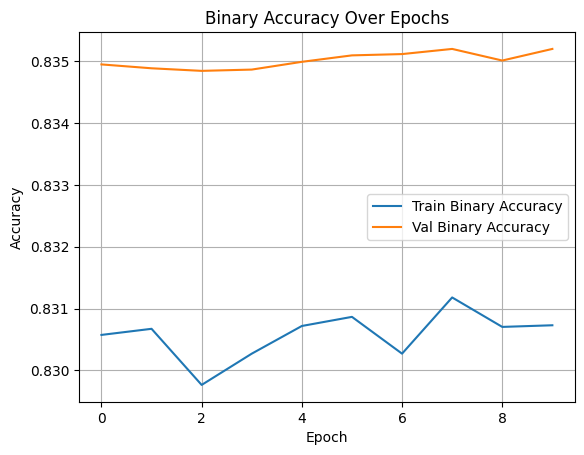

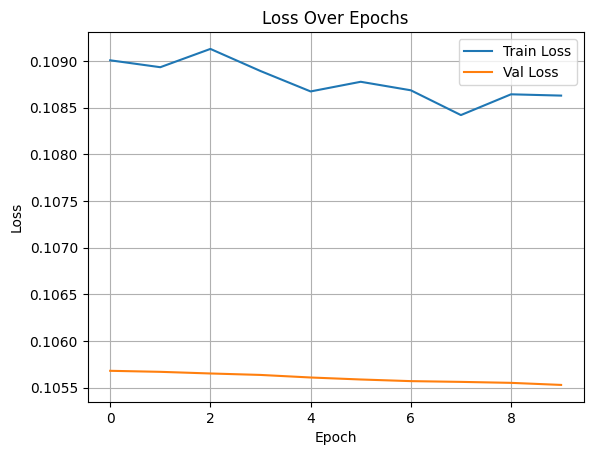

In [ ]:
import matplotlib.pyplot as plt

h = history.history

history = h.copy()

# Plot binary accuracy
plt.plot(history['binary_accuracy'], label='Train Binary Accuracy')
plt.plot(history['val_binary_accuracy'], label='Val Binary Accuracy')
plt.title('Binary Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot loss
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Grab a batch from the test dataset
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)

    # Print the first 5 predictions vs actual labels
    for i in range(8):
        print(f"Actual:     {labels[i].numpy().round(2)}")
        print(f"Predicted:  {predictions[i].round(2)}\n")

from sklearn.metrics import classification_report
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = np.vstack([y for _, y in test_dataset])
print(classification_report(y_true, y_pred, target_names=all_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Actual:     [0. 0. 0. 0. 0. 1. 0.]
Predicted:  [0.19 0.23 0.11 0.41 0.37 0.43 0.24]

Actual:     [0. 0. 0. 0. 0. 1. 0.]
Predicted:  [0.11 0.25 0.07 0.33 0.67 0.24 0.34]

Actual:     [0. 0. 0. 0. 0. 1. 0.]
Predicted:  [0.23 0.23 0.12 0.42 0.4  0.42 0.27]

Actual:     [0. 0. 0. 0. 0. 0. 1.]
Predicted:  [0.18 0.38 0.08 0.3  0.34 0.37 0.38]

Actual:     [0. 0. 0. 0. 0. 1. 0.]
Predicted:  [0.16 0.17 0.09 0.45 0.24 0.52 0.24]

Actual:     [0. 0. 0. 0. 0. 0. 1.]
Predicted:  [0.11 0.22 0.07 0.34 0.29 0.43 0.53]

Actual:     [1. 0. 0. 0. 0. 0. 0.]
Predicted:  [0.35 0.3  0.13 0.39 0.27 0.36 0.38]

Actual:     [0. 1. 0. 0. 1. 0. 0.]
Predicted:  [0.2  0.62 0.1  0.39 0.35 0.27 0.37]

476/476 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step
                        precision    recall  f1-score   support

        Cardiac Issues       0.00      0.00      0.00       155
  Fluid Related Issues       0.74      0.41      0.53       881
                Hernia       0.00      0.00     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Phase 5

In [ ]:
from tensorflow.keras.metrics import Recall

# === Checkpoint ===
checkpoint5 = ModelCheckpoint(
    "/content/drive/MyDrive/best_model_final5.weights.h5",
    monitor="val_binary_accuracy",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    verbose=1
)

# === Phase 5: Fine-tune with Focal Loss ===
print("Phase 5: Focal Loss")
model.compile(
    optimizer=Adam(1e-6),
    loss=focal_loss(gamma=1.5, alpha=ALPHA_FIXED),
    metrics=[BinaryAccuracy(), Recall()]
)
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[checkpoint5])

Phase 5: Focal Loss
Epoch 1/10
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - binary_accuracy: 0.8302 - loss: 0.1090 - recall_2: 0.2388
Epoch 1: val_binary_accuracy improved from -inf to 0.83507, saving model to /content/drive/MyDrive/best_model_final5.weights.h5
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 382s 104ms/step - binary_accuracy: 0.8302 - loss: 0.1090 - recall_2: 0.2388 - val_binary_accuracy: 0.8351 - val_loss: 0.1055 - val_recall_2: 0.2262
Epoch 2/10
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - binary_accuracy: 0.8308 - loss: 0.1086 - recall_2: 0.2418
Epoch 2: val_binary_accuracy improved from 0.83507 to 0.83516, saving model to /content/drive/MyDrive/best_model_final5.weights.h5
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 342s 98ms/step - binary_accuracy: 0.8308 - loss: 0.1086 - recall_2: 0.2418 - val_binary_accuracy: 0.8352 - val_loss: 0.1055 - val_recall_2: 0.2276
Epoch 3/10
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - binary_accuracy: 0.8304 - loss: 0.1087 - recall_2: 0.2381
Epoch 3: val_binary

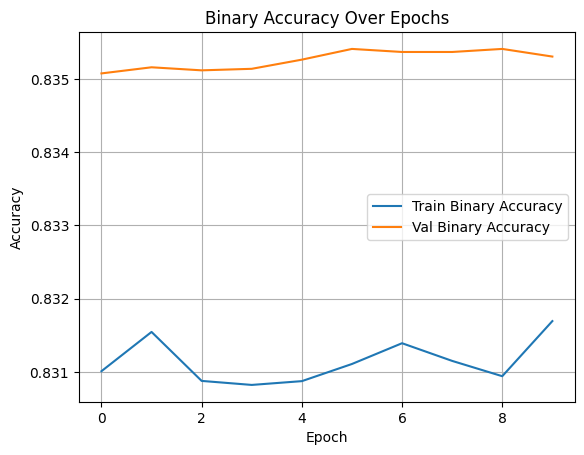

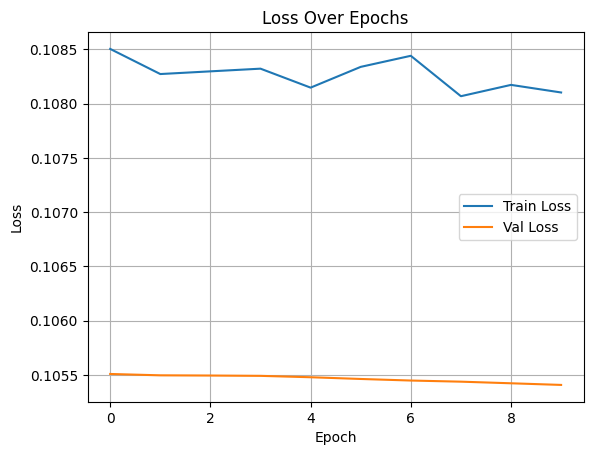

In [ ]:
import matplotlib.pyplot as plt

h = history.history

history = h.copy()

# Plot binary accuracy
plt.plot(history['binary_accuracy'], label='Train Binary Accuracy')
plt.plot(history['val_binary_accuracy'], label='Val Binary Accuracy')
plt.title('Binary Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot loss
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Final Evaulation on EfficientNet

After completing over 50 epochs of training on our final version EfficientNet, we ran a battery of tests.

In [ ]:
import matplotlib.pyplot as plt

# Grab a batch from the test dataset
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)

    # Print the first 5 predictions vs actual labels
    for i in range(8):
        print(f"Actual:     {labels[i].numpy().round(2)}")
        print(f"Predicted:  {predictions[i].round(2)}\n")

from sklearn.metrics import classification_report
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = np.vstack([y for _, y in test_dataset])
print(classification_report(y_true, y_pred, target_names=all_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Actual:     [0. 0. 0. 0. 0. 1. 0.]
Predicted:  [0.19 0.23 0.11 0.41 0.38 0.43 0.24]

Actual:     [0. 0. 0. 0. 0. 1. 0.]
Predicted:  [0.11 0.25 0.07 0.33 0.68 0.24 0.34]

Actual:     [0. 0. 0. 0. 0. 1. 0.]
Predicted:  [0.23 0.22 0.12 0.42 0.4  0.41 0.27]

Actual:     [0. 0. 0. 0. 0. 0. 1.]
Predicted:  [0.18 0.37 0.08 0.29 0.34 0.37 0.38]

Actual:     [0. 0. 0. 0. 0. 1. 0.]
Predicted:  [0.15 0.17 0.08 0.45 0.23 0.52 0.24]

Actual:     [0. 0. 0. 0. 0. 0. 1.]
Predicted:  [0.11 0.21 0.06 0.34 0.28 0.43 0.54]

Actual:     [1. 0. 0. 0. 0. 0. 0.]
Predicted:  [0.36 0.3  0.13 0.39 0.26 0.36 0.38]

Actual:     [0. 1. 0. 0. 1. 0. 0.]
Predicted:  [0.2  0.63 0.1  0.39 0.35 0.27 0.37]

476/476 ━━━━━━━━━━━━━━━━━━━━ 40s 71ms/step
                        precision    recall  f1-score   support

        Cardiac Issues       1.00      0.01      0.01       155
  Fluid Related Issues       0.74      0.42      0.53       881
                Hernia       0.00      0.00     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import classification_report

# Collect predictions and true labels
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int))  # Threshold at 0.5

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
print(classification_report(y_true, y_pred, target_names=all_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np

class_supports = np.sum(y_true, axis=0)
for label, count in zip(all_labels, class_supports):
    print(f"{label:<25} : {int(count)}")

Cardiac Issues            : 155
Fluid Related Issues      : 881
Hernia                    : 21
Infection/Infiltration    : 1062
Lung Structure Issues     : 1066
No Finding                : 1015
Nodule/Mass               : 727


In [ ]:
# Assuming test_dataset is a tf.data.Dataset object
total = 0
for batch in test_dataset:
    total += batch[0].shape[0]  # batch[0] is the image batch
print(f"Total test samples: {total}")

Total test samples: 3801


In [ ]:
from sklearn.metrics import roc_auc_score

# For multi-label, you need probabilities, not thresholded outputs
probs = model.predict(test_dataset)
roc_auc_scores = {}
for i, label in enumerate(all_labels):
    try:
        score = roc_auc_score(y_true[:, i], probs[:, i])
        roc_auc_scores[label] = score
    except ValueError:
        roc_auc_scores[label] = "Undefined (only one class present)"

print(roc_auc_scores)

476/476 ━━━━━━━━━━━━━━━━━━━━ 27s 56ms/step
{'Cardiac Issues': np.float64(0.8761541592200025), 'Fluid Related Issues': np.float64(0.835256091303469), 'Hernia': np.float64(0.672461577223482), 'Infection/Infiltration': np.float64(0.6287825501629871), 'Lung Structure Issues': np.float64(0.7811789361038034), 'No Finding': np.float64(0.7648340223283908), 'Nodule/Mass': np.float64(0.7007814576529959)}


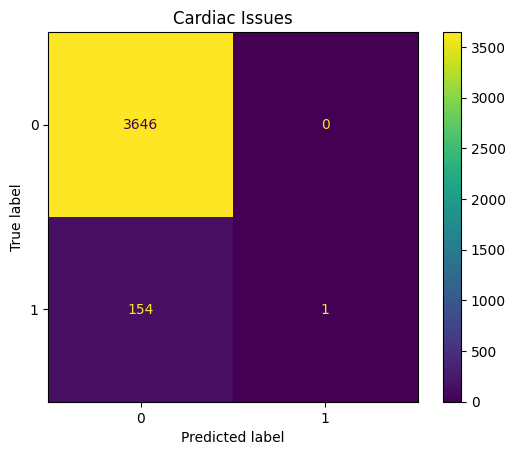

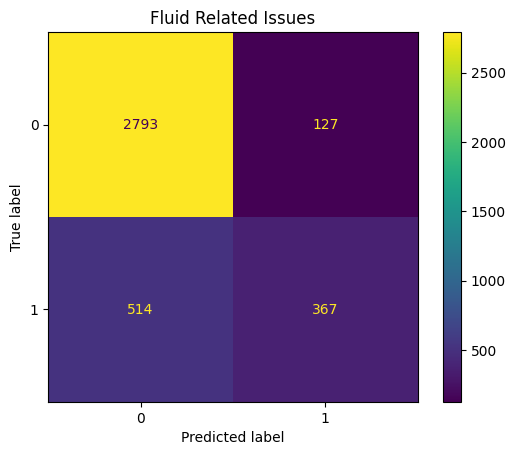

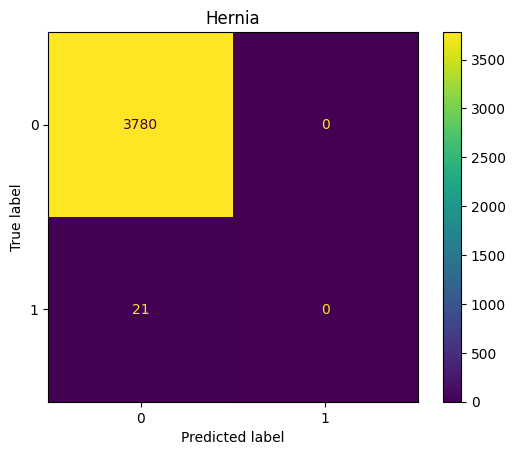

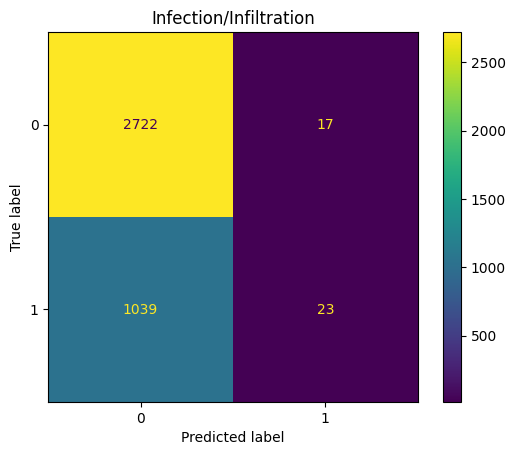

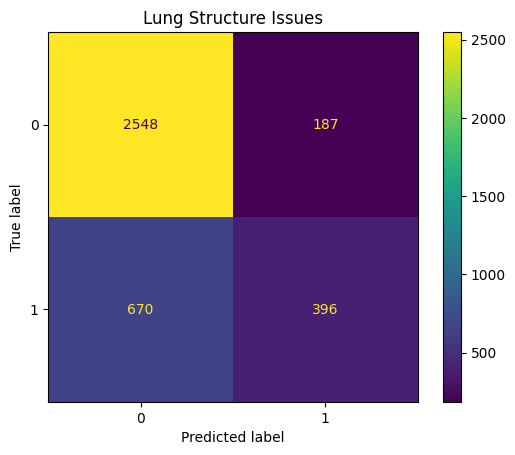

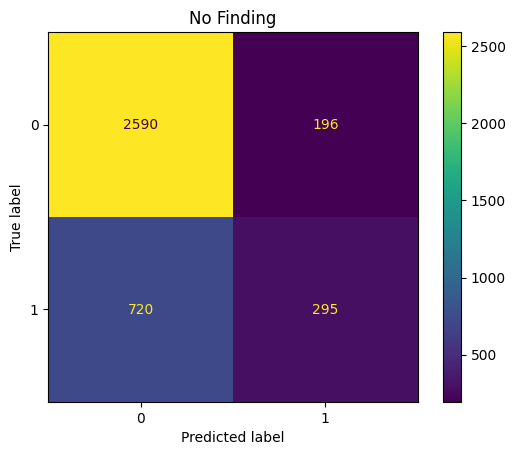

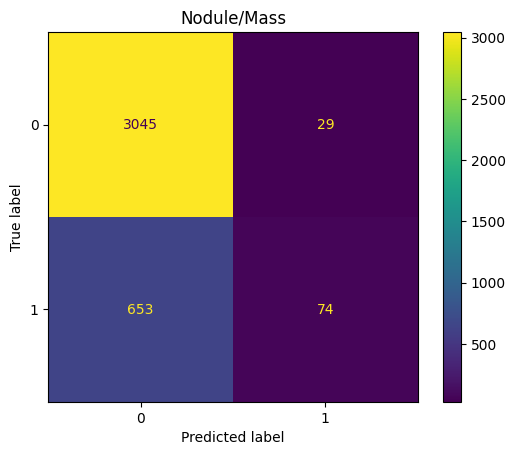

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for i, label in enumerate(all_labels):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(label)
    plt.show()

## Optimal Threshold Search

Finally, after completing training we searched for the optimal thresholds to produce the best results, and re-ran the test above, giving us our final results.

In [ ]:
from sklearn.metrics import f1_score

best_thresholds = []
for i in range(y_true.shape[1]):
    best_f1 = 0
    best_t = 0.5
    for t in np.linspace(0.1, 0.9, 17):
        preds = (probs[:, i] > t).astype(int)
        f1 = f1_score(y_true[:, i], preds)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    best_thresholds.append(best_t)
    print(f"{all_labels[i]}: Best F1={best_f1:.3f} at threshold={best_t:.2f}")

Cardiac Issues: Best F1=0.361 at threshold=0.30
Fluid Related Issues: Best F1=0.598 at threshold=0.40
Hernia: Best F1=0.018 at threshold=0.10
Infection/Infiltration: Best F1=0.461 at threshold=0.35
Lung Structure Issues: Best F1=0.569 at threshold=0.40
No Finding: Best F1=0.560 at threshold=0.40
Nodule/Mass: Best F1=0.424 at threshold=0.35


In [ ]:
# Custom thresholds for each class
thresholds = {
    'Cardiac Issues': 0.30,
    'Fluid Related Issues': 0.40,
    'Hernia': 0.10,
    'Infection/Infiltration': 0.35,
    'Lung Structure Issues': 0.40,
    'No Finding': 0.40,
    'Nodule/Mass': 0.35
}

# Make sure the label order matches `all_labels`
threshold_array = np.array([thresholds[label] for label in all_labels])

# Collect predictions and true labels
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    # Apply different threshold for each class
    y_pred.extend((preds > threshold_array).astype(int))

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Re-run the classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=all_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


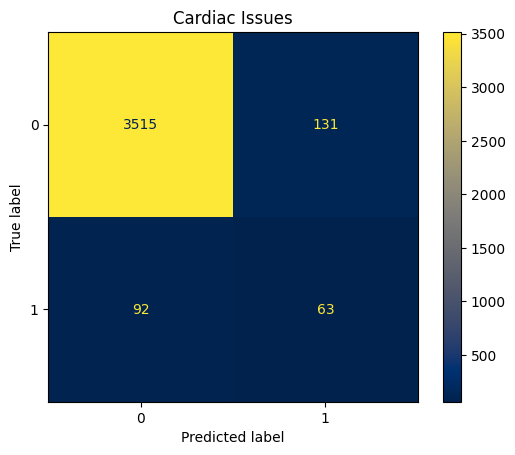

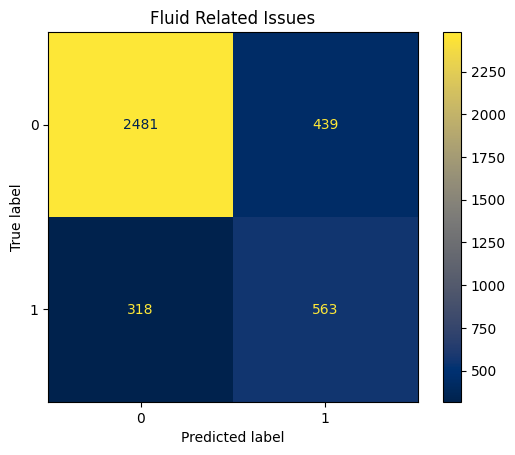

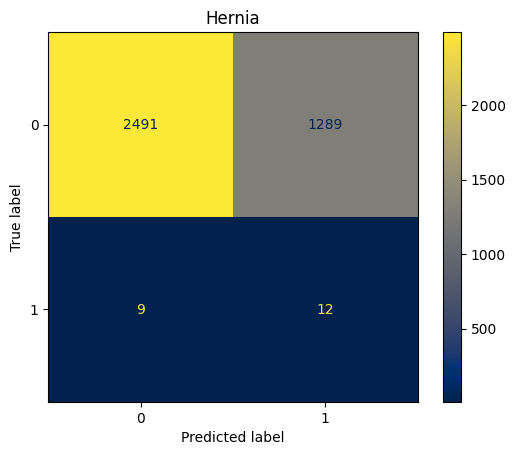

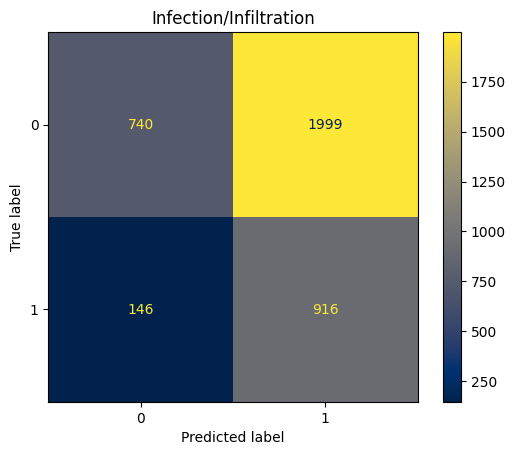

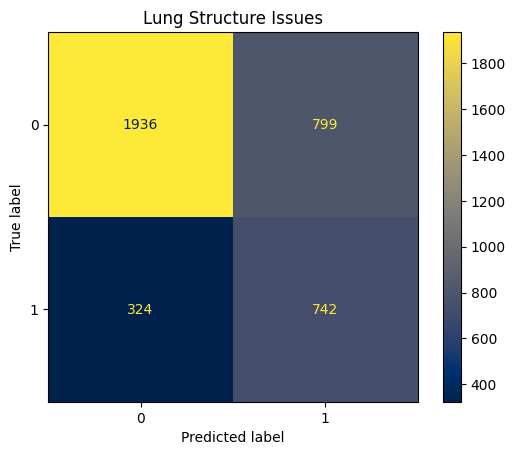

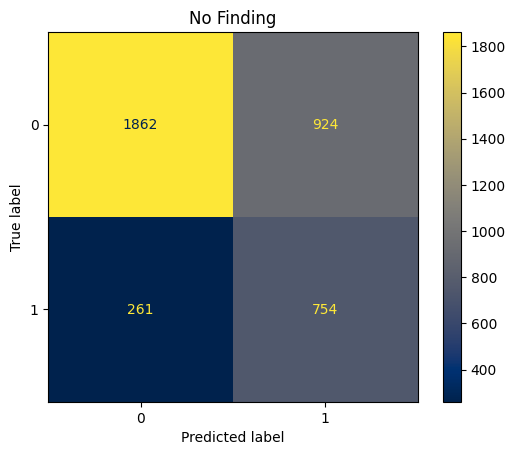

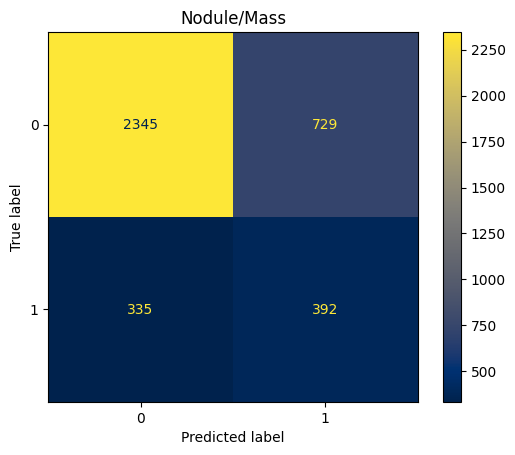

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for i, label in enumerate(all_labels):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='cividis')
    plt.title(label)
    plt.show()

# Conclusions on EfficientNet

After several rounds of training and experimentation, we our final setup struck a balance between recall and F1 score across all 7 categories.

Our architecture consised of using EfficientNetB0 with pretrained ImageNet weights as the backbone, followed by a global average pooling layer, a 128-unit dense layer for extra expressiveness, and a sigmoid output layer to handle the multi-label classification task.

While we initially kept the backbone frozen for a warm-up phase using binary crossentropy with label smoothing, we fully later unfroze it before moving on to focal loss fine-tuning. We did this because we found that using 1 initial epoch of binary crossentropy, allowed the network to break out of it's local lazy minima of predicting 0 for all classes.

Afterwards, we trained using a focal loss *mostly* with an alpha of 0.8 and gamma of 2.0. This setup helped the model focus more on the difficult, underrepresented classes. And for the final stretch, we reduced gamma to 1.5 to ease the penalty on confident predictions and help stabilize performance. This tweak made a noticeable difference by helping it to generalize better without punishing good predictions too much.

Finally, as explained in our paper and presentaiton we opted to optimize our models towards recall. To really push recall, especially for classes with low support, we did per-class threshold tuning using the validation F1 score as our guide. That decision paid off. For instance, “Infection/Infiltration” jumped from an F1 of 0.04 to 0.46, and “Nodule/Mass” rose from 0.18 to 0.42. Overall, our macro-averaged F1 score went from 0.23 to 0.43, and micro-averaged F1 from 0.35 to 0.47.